In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import uproot
import ROOT
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.integrate as intg 
from scipy.stats import norm
from numpy.random import normal
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
import sipm.util.functions as func

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


# Change channel mapping in calibration file from liq5

In [2]:
# store_in = pd.HDFStore('data/calibration_liq5_2023-12-13.h5')
# keys = store_in.keys()
# store_out = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# for k in keys:
#     df = store_in.get(k)
#     df['channel'] = [0,5,6,3,4,1,2,7]
#     df = df.sort_values('channel')
#     df.index = df['channel'].to_numpy()
#     df['max_amp'] = [1490]*4+[1440]*4
#     store_out.put(k,df)
# store_out.close()

In [3]:
# store_new = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# df = store_new.get('98V')
# print(df)
# store_new.close()

## Visualize waveforms from original binary files

/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/wave0.dat
167 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/wave1.dat
167 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/wave2.dat
167 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/wave3.dat
167 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/wave4.dat
167 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/wave5.dat
167 events
/scratch/gpfs/GALBIATI/data/sipm//xenon_doping/2024-02-28/2024-02-28_volt_98_light

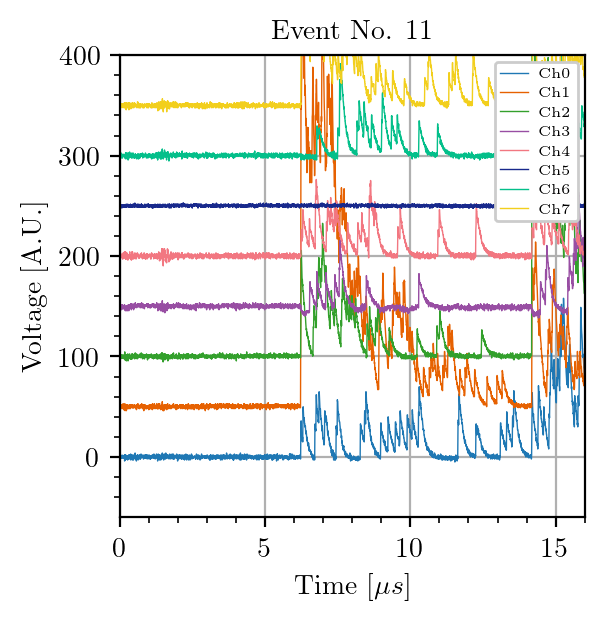

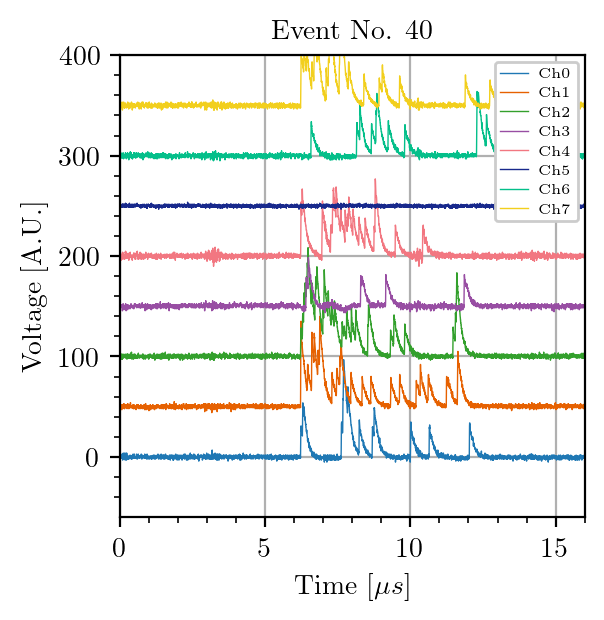

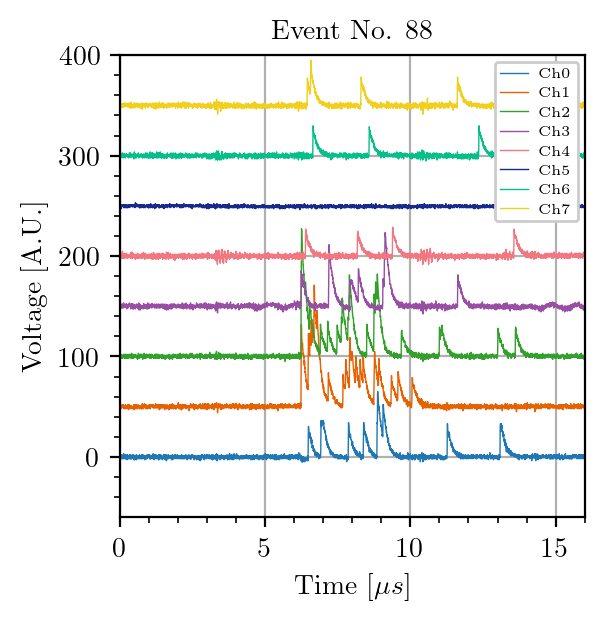

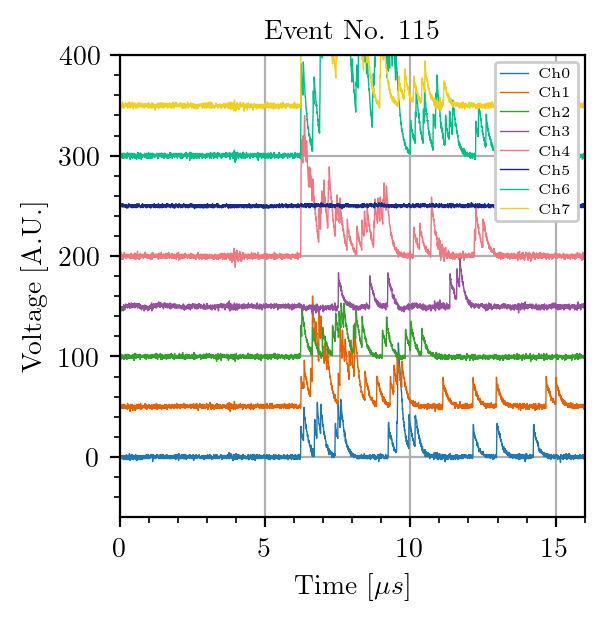

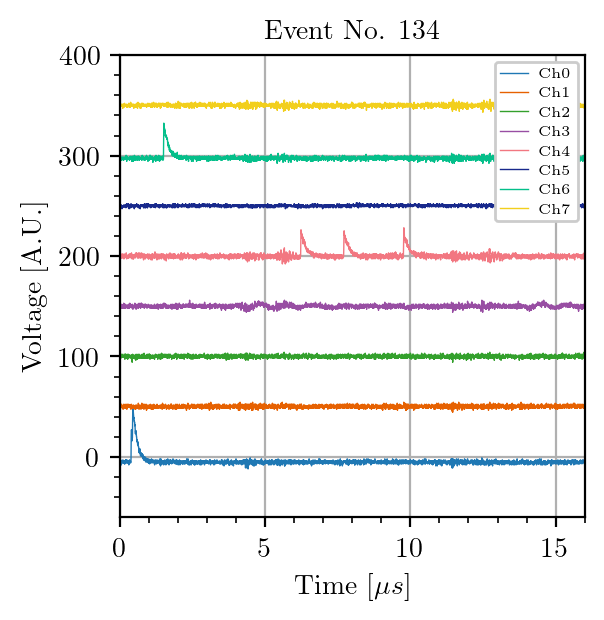

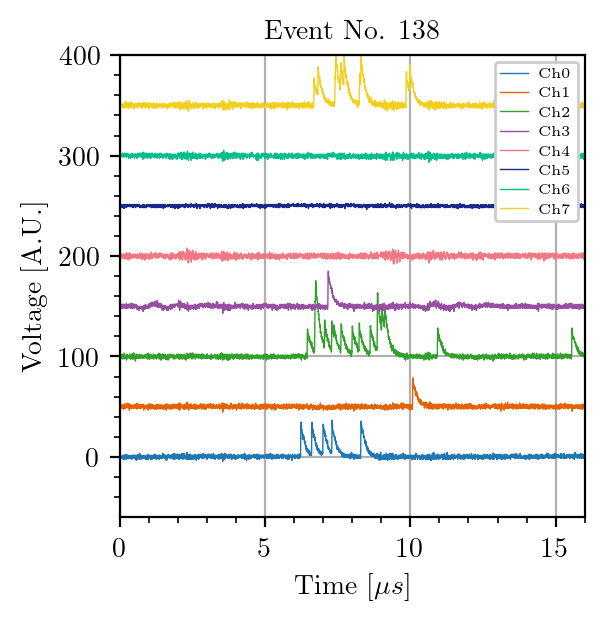

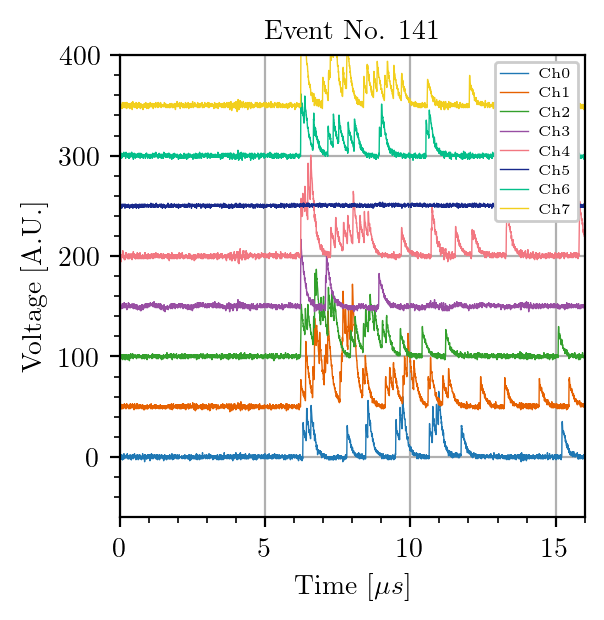

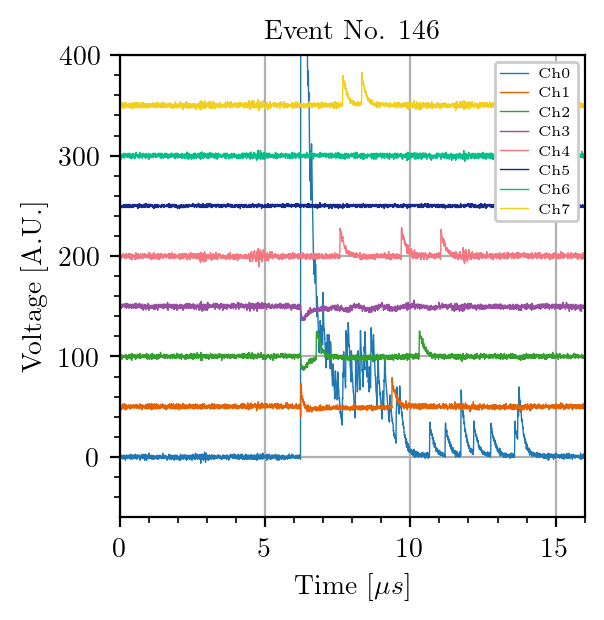

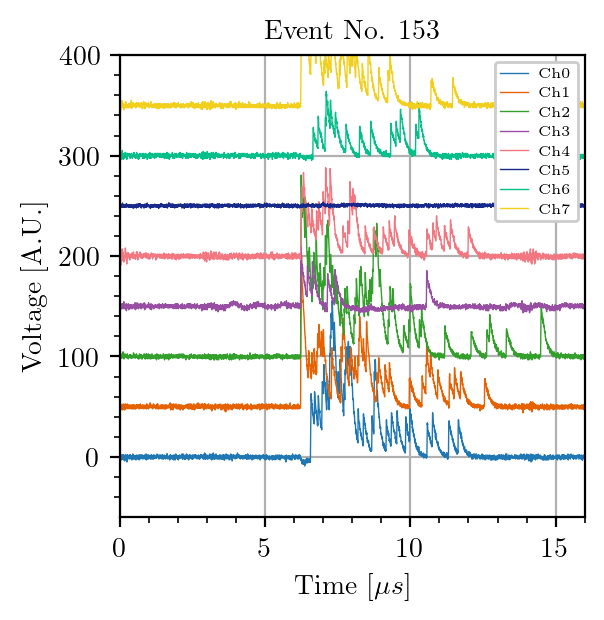

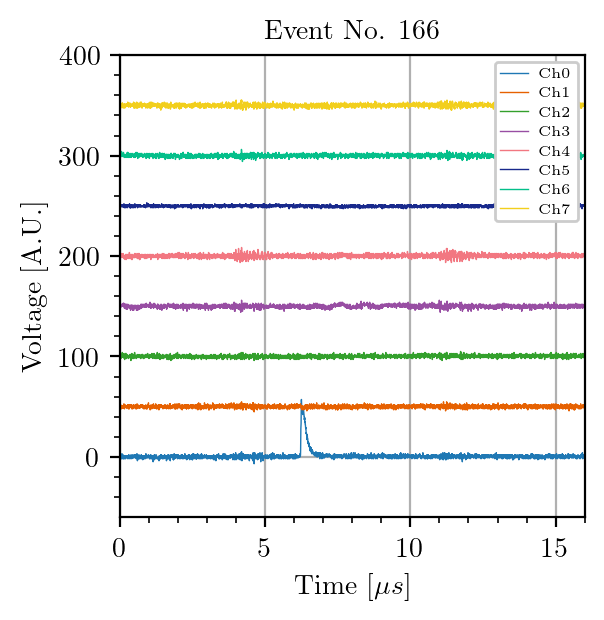

In [82]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/xenon_doping/'
direc = '2024-02-28/2024-02-28_volt_98_light_scintillation_source_co60_xenon_1_cond_monitor/7/'
# evid = np.arange(0, 10)
evid = [ 11  ,40 , 88, 115 ,134 ,138 ,141 ,146 ,153, 166]
dset = wfd.WaveformDataset(path='{}{}'.format(data_dir, direc), pol=-1, channels=range(8))
wfs = []
for ch in np.arange(8):
    wfs.append(dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)[0])
wfs = np.array(wfs)
print(wfs.shape)
for i in range(wfs.shape[1]):
    plt.figure(i, figsize=(3, 3))
    for ch in range(wfs.shape[0]):
        plt.plot(dset.ch[ch].time, wfs[ch,i]+ch*50, label=f'Ch{ch}', linewidth=0.5)
    plt.legend(loc='upper right', fontsize=5)
    plt.xlabel(r'Time [$\mu s$]')
    plt.ylabel(r'Voltage [A.U.]')
    plt.minorticks_on()
    plt.grid()
    plt.xlim(0, 16)
    plt.ylim(-60, 400)
    plt.title(f'Event No. {evid[i]}')

## List pre-processed h5 files

In [4]:
path = "/scratch/gpfs/as111/results/"
# date = '2024-02-23'
# files = [[],[],[],[],[]] # Co-60, Na-22, Ba-133, Eu-152, Backgrounds
# files[0].extend(glob(f"{path}{date}/*source_co60*scintillation_pulse_liq6.h5"))
# files[1].extend(glob(f"{path}{date}/*source_na22*scintillation_pulse_liq6.h5"))
# files[2].extend(glob(f"{path}{date}/*source_ba133*scintillation_pulse_liq6.h5"))
# files[3].extend(glob(f"{path}{date}/*source_eu152*scintillation_pulse_liq6.h5"))
# files[4].extend(glob(f"{path}{date}/*source_none*scintillation_pulse_liq6.h5"))
# print(len(files[0]), files[0])
# print(len(files[1]), files[1])
# print(len(files[2]), files[2])
# print(len(files[3]), files[3])
# print(len(files[4]), files[4])
date = '2024-03-01'
files_ = glob(f"{path}{date}/*cond_monitor_overnight*scintillation_pulse_liq6.h5")
print(files_)
files = []
for i in range(len(files_)):
    files.append(glob(f"{path}{date}/*cond_monitor_overnight*run{i}_scintillation_pulse_liq6.h5"))
files


['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run11_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run1_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run4_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run0_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run10_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run16_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-03-01/2024-03-01_vol

[['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run0_scintillation_pulse_liq6.h5'],
 ['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run1_scintillation_pulse_liq6.h5'],
 ['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run2_scintillation_pulse_liq6.h5'],
 ['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run3_scintillation_pulse_liq6.h5'],
 ['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run4_scintillation_pulse_liq6.h5'],
 ['/scratch/gpfs/as111/results/2024-03-01/2024-03-01_volt_98_light_scintillation_cond_monitor_overnight_source_co60_xenon_1_run5_scintillation_pulse_liq6.h5'],
 ['/scratch/gpfs/as111/results/2024-03-0

## Load h5 files

In [5]:
def load_data(file_list, channel_list, volt):
    df_ch = {}
    for ch in channel_list:
        df_ch[ch] = []
        for f in file_list:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            df_ch[ch].append(df)
            df = None
        df_ch[ch] = pd.concat(df_ch[ch]).sort_index()
        if ch!=-1:
            df_ch[ch].rename(columns=lambda x: x+f'_{ch}',inplace=True)
    df_ch = pd.concat(list(df_ch.values()),axis=1)
    return df_ch

In [6]:
data = {}
channels = np.arange(-1,8)
volt = 98
# cond = ['Co-60','Na-22','Ba-133','Eu-152','Backgrounds']
cond = np.arange(12)
for i, c in enumerate(cond):
    data[c] = load_data(files[i],channels,volt)
    print(f'{c}: {data[c].shape[0]} events')
print('columns: ', list(data[cond[0]].columns))

0: 50292 events
1: 50393 events
2: 50334 events
3: 50527 events
4: 50481 events
5: 50448 events
6: 50266 events
7: 50268 events
8: 50445 events
9: 50464 events
10: 50459 events
11: 50482 events
columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 

## Read calibration file and get PE scale

In [7]:
calib = {}
pe_scale = {}
voltages = [92,94,96,98,100]
for volt in voltages:
    calib[volt] = pd.read_hdf('data/calibration_liq6_2023-12-13.h5', key=f'{volt}V')
    pe_scale[volt] = calib[volt]['Qavg']/(1-calib[volt]['DiCT'])

## Convert integral to PE count

In [8]:
def convert_to_pe(df_data,df_pe_scale,channels):
    pe_ch = df_data[[f'integral_5p00us_{ch}' for ch in range(8)]]
    pe_ch.columns = np.arange(8)
    pe_ch = pe_ch/df_pe_scale
    df_pe = pe_ch.iloc[:,channels].sum(axis=1)
    df_pe.name = 'pe_' + ''.join([str(c) for c in channels])
    pe_ch = None
    return df_pe

In [9]:
channels_nofs = [1,2,4,7]
channels_fs = [0,3,5,6]
volt = 98
for i, c in enumerate(cond):
    df_nofs, df_fs = convert_to_pe(data[c],pe_scale[volt],channels_nofs), convert_to_pe(data[c],pe_scale[volt],channels_fs)
    data[c][df_nofs.name] = df_nofs
    df_nofs = None
    data[c][df_fs.name] = df_fs
    df_fs = None
    data[c]['pe_01234567'] = data[c]['total_pe']
    data[c]['fs_pe'] = data[c]['pe_0356']
    data[c]['nofs_pe'] = data[c]['pe_1247']
print('columns: ', list(data[cond[0]].columns))

columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'baseline_mean_6', 'baseline_rms_6', 'integral_0p30us_6', 'integral_5p00us_6', 'fired_6', 'amplitude_6', 'peakpos

## Baseline cut
Remove pre-trigger pulse by pre-trigger RMS

In [12]:
def get_bsl_filt(df_data,channels,rms_thre_ch):
    df_bsl_filt = {}
    for ch in channels:
        df_bsl_filt[f'bsl_filt_{ch}'] = df_data[f'baseline_rms_{ch}']<rms_thre_ch[ch]
        # print(df_bsl_filt[f'bsl_filt_{ch}'].sum())
    df_bsl_filt = pd.DataFrame(df_bsl_filt)
    df_bsl_filt['bsl_filt'] =  df_bsl_filt[[f'bsl_filt_{ch}' for ch in channels]].all(axis=1)
    return df_bsl_filt

def get_bsl_rms_hist(df_data,channels,bins,range):
    hist_ch = {}
    for ch in channels:
        hist_ch[ch] = np.histogram(df_data[f'baseline_rms_{ch}'], bins=bins, range=range)
    return hist_ch

def get_bsl_mean_hist(df_data,channels,bsl_filt,bins,range):
    hist_ch = {}
    for ch in channels:
        if bsl_filt:
            hist_ch[ch] = np.histogram(df_data.loc[df_data[f'bsl_filt_{ch}'],f'baseline_mean_{ch}'], bins=bins, range=range)
        else:
            hist_ch[ch] = np.histogram(df_data[f'baseline_mean_{ch}'], bins=bins, range=range)
    return hist_ch

## Apply RMS cut

In [15]:
rms_threshold = {'Co-60':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Na-22':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Ba-133':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Eu-152':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 'Backgrounds':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0]}
for c in cond:
    # df_bsl_filt = get_bsl_filt(data[c],np.arange(8),rms_threshold[c])
    df_bsl_filt = get_bsl_filt(data[c],np.arange(8),rms_threshold['Co-60'])
    data[c][df_bsl_filt.columns] = df_bsl_filt
    df_bsl_filt = None

## Get mean and RMS histograms

In [16]:
baseline = {'rms_hist':{}, 'mean_hist':{}, 'mean_hist_filt':{}}
# Produce baseline rms histograms
bins = 500
range_min = 0
range_max = 10
for c in cond:
    baseline['rms_hist'][c] = get_bsl_rms_hist(data[c],np.arange(8),bins=bins,range=[range_min,range_max])
# Produce baseline mean histograms
nbins = 500
range_min = 3800
range_max = 4000
for c in cond:
    baseline['mean_hist'][c] = get_bsl_mean_hist(data[c],np.arange(8),bsl_filt=False,bins=bins,range=[range_min,range_max])
    baseline['mean_hist_filt'][c] = get_bsl_mean_hist(data[c],np.arange(8),bsl_filt=True,bins=bins,range=[range_min,range_max])


Text(0.07, 0.5, 'Count')

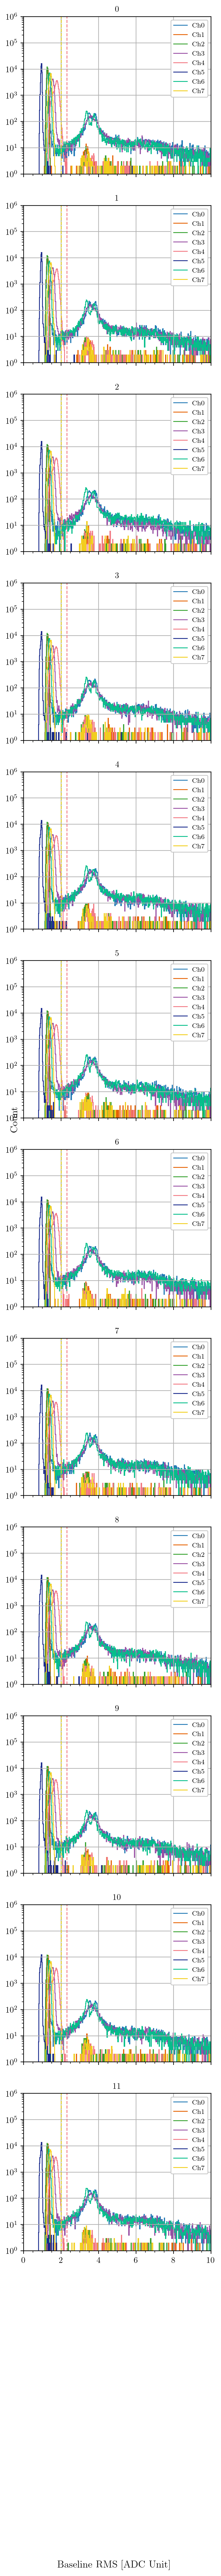

In [17]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(12, 1, sharex=True, sharey=True)
fig.set_size_inches(4,48)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            *baseline['rms_hist'][c][ch],
            label=f'Ch{ch}', color=f'C{j}'
        )
        # th = rms_threshold[c][ch]
        th = rms_threshold['Co-60'][ch]
        axs[i].plot([th, th], [1, 1e6], f'C{j}--', linewidth=1)
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

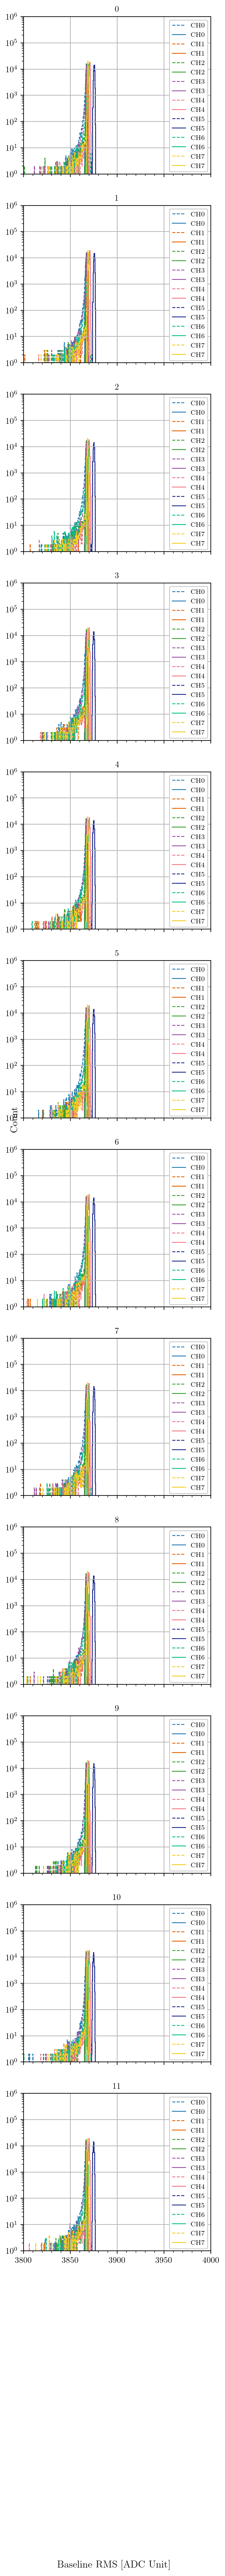

In [18]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(12, 1, sharex=True, sharey=True)
fig.set_size_inches(4,48)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            *baseline['mean_hist'][c][ch],
            label=f'CH{ch}', color=f'C{j}', linestyle='--'
        )
        axs[i].stairs(
            *baseline['mean_hist_filt'][c][ch],
            label=f'CH{ch}', color=f'C{j}'
        )
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0)
fig.supylabel('Count', x=0.07)

In [57]:
# # Make plots for selected dataset
# ch = 4
# c = 'Backgrounds'
# print(f'Plots for {c} ch{ch}')
# fig, axs = plt.subplots(1, 2)
# fig.set_size_inches(8, 3)

# # rms
# axs[0].stairs(*baseline['rms_hist'][c][ch])
# th = rms_threshold[c][ch]
# axs[0].plot([th, th], [1, 1e6], 'k--', linewidth=1)
# axs[0].set_ylim(1, 1e6)
# axs[0].set_yscale('log')
# axs[0].set_xlabel('Baseline RMS [ADC Unit]')
# axs[0].set_ylabel('Count')
# axs[0].minorticks_on()
# axs[0].grid()

# # mean
# axs[1].stairs(*baseline['mean_hist'][c][ch],
#               label='Before cut')
# axs[1].stairs(*baseline['mean_hist_filt'][c],
#               label='After cut')
# axs[1].legend()
# axs[1].set_yscale('log')
# axs[1].set_ylim(1, 1e6)
# axs[1].set_xlim(3800, 4000)
# axs[1].set_xlabel('Baseline Mean [ADC Unit]')
# axs[1].set_ylabel('Count')
# axs[1].minorticks_on()
# axs[1].grid()

## Saturated peaks
Find maximum amplitude and remove those events reaching maximum amplitude.

In [19]:
def get_sat_filt(df_data,channels,sat_list):
    df_sat_filt = {}
    for ch in channels:
        df_sat_filt[f'sat_filt_{ch}'] = df_data[f'amplitude_{ch}']<sat_list[ch]
    df_sat_filt = pd.DataFrame(df_sat_filt)
    df_sat_filt['sat_filt'] =  df_sat_filt[[f'sat_filt_{ch}' for ch in range(8)]].all(axis=1)
    return df_sat_filt
    

In [20]:
amp_sat = [1490]*4+[1440]*4
for c in cond:
    df_sat_filt = get_sat_filt(data[c],np.arange(8),amp_sat)
    data[c][df_sat_filt.columns] = df_sat_filt
    df_sat_filt = None

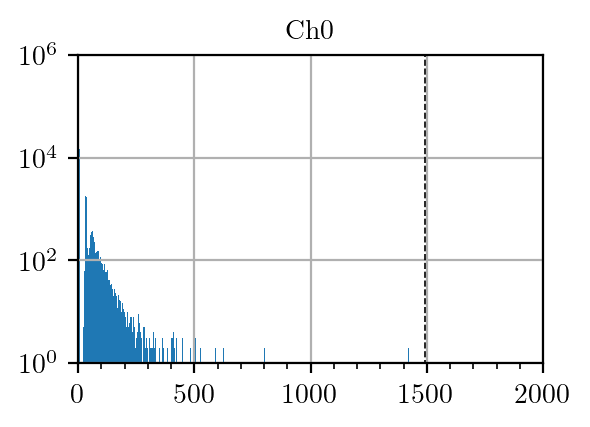

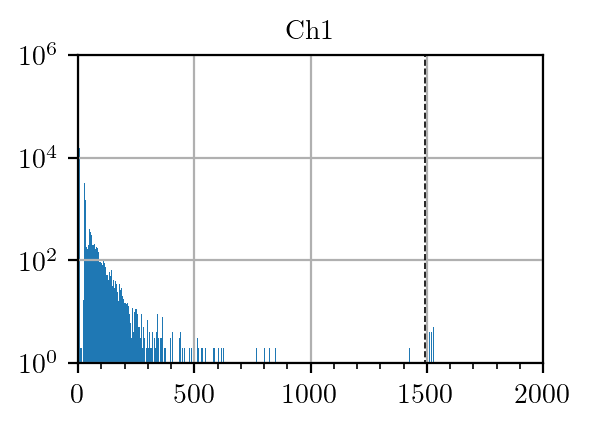

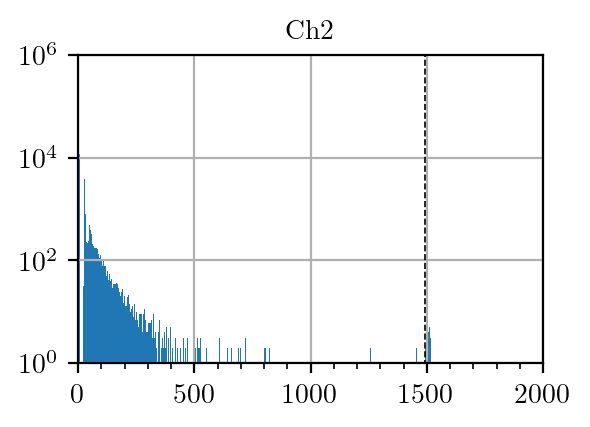

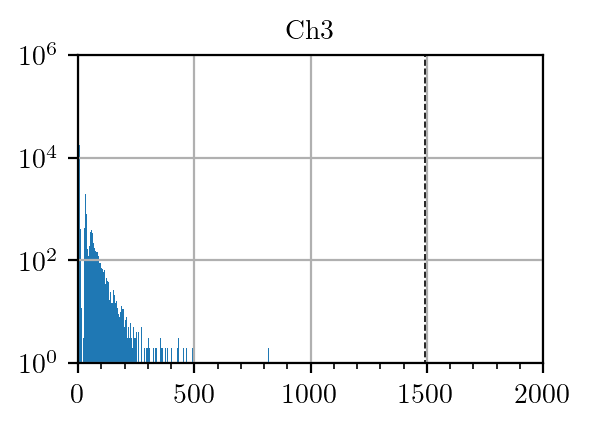

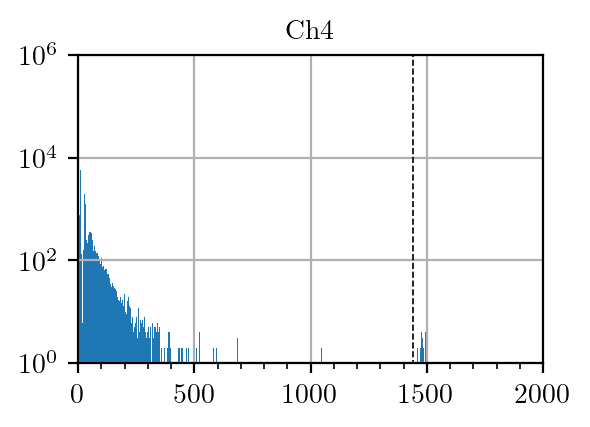

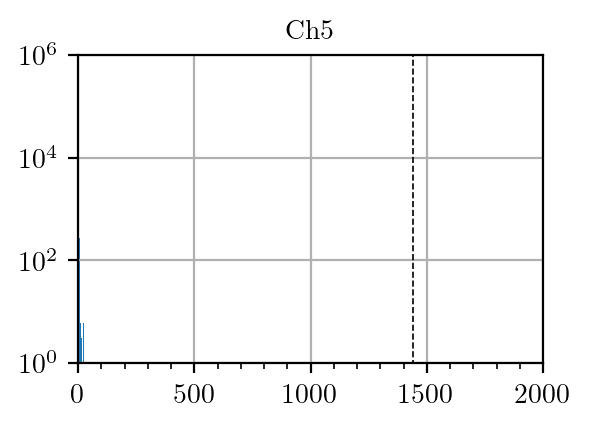

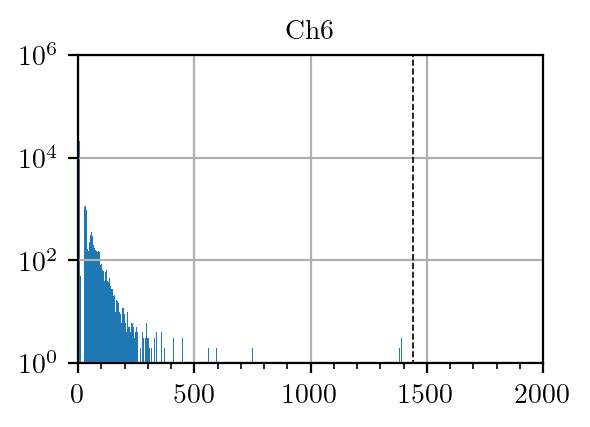

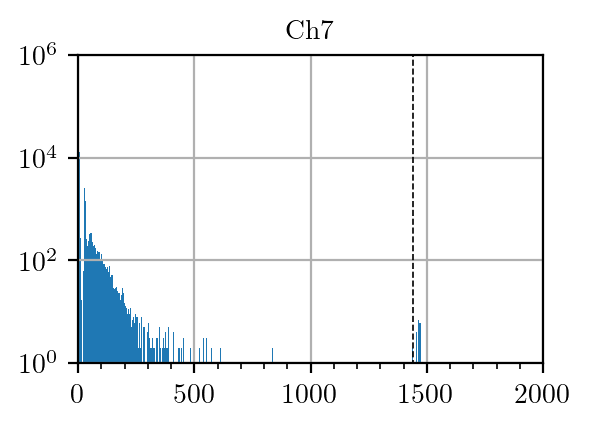

In [21]:
for ch in np.arange(8):
    plt.figure(ch,figsize=(3,2))
    plt.hist(data[cond[0]][f'amplitude_{ch}'],bins=np.linspace(0,1600,1000))
    plt.plot([amp_sat[ch]]*2,[0,1e6],'k--',linewidth=0.6)
    plt.title(f'Ch{ch}')
    plt.yscale('log')
    plt.grid()
    plt.minorticks_on()
    plt.ylim(0,1e6)

## PE distributions
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm avg}/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.3~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely pile-ups.
These are rejected by requiring $F_{\rm prompt}>0.1$.

In [26]:
def get_fp_filt(df_data,channel_groups,fp_dict,length):
    df_fp_filt = {}
    for g in channel_groups:
        df_fp_filt[f'fp_filt_{g}'] = df_data[f'fprompt_{length}_{g}']>fp_dict[g]
    df_fp_filt = pd.DataFrame(df_fp_filt)
    df_fp_filt['fp_filt'] =  df_fp_filt[[f'fp_filt_{g}' for g in channel_groups]].all(axis=1)
    return df_fp_filt

def get_fp_hist2d(df_data,channel_groups,length,bins_xy,range_xy,log_scale):
    hist2d_g = {}
    for g in channel_groups:
        # filt = df_data['bsl_filt']
        filt = df_data['bsl_filt_1'] & df_data['bsl_filt_2'] & df_data['bsl_filt_4'] & df_data['bsl_filt_7']
        hist2d_g[g] = list(np.histogram2d(
            df_data[f'pe_{g}'][filt], 
            df_data[f'fprompt_{length}_{g}'][filt], 
            bins=bins_xy, range=range_xy
        ))
        temp = hist2d_g[g][0].T
        hist2d_g[g][0], hist2d_g[g][1] = np.meshgrid(
            hist2d_g[g][1], hist2d_g[g][2]
        )
        if log_scale:
            hist2d_g[g][2] = np.log10(temp)
        else:
            hist2d_g[g][2] = temp
    return hist2d_g

In [30]:
# Initialize container
fprompt = {}
positions = ['all','fs','nofs']
groups = ['01234567','0356','1247']
fp_thre = {'01234567':0.05,'0356':0.1,'1247':0.05}

In [31]:
# Produce fprompt 2D histograms
binsx = 500
range_minx = -10
range_maxx = 600
binsy = 500
range_miny = 0
range_maxy = 1

for c in cond:
    fprompt[c] = get_fp_hist2d(data[c],groups,'0p30us',bins_xy=[binsx,binsy],range_xy=[[range_minx,range_maxx],[range_miny,range_maxy]],log_scale=True)
    df_fp_filt = get_fp_filt(data[c],groups,fp_thre,'0p30us')
    data[c][df_fp_filt.columns] = df_fp_filt
    df_fp_filt = None

Text(0.07, 0.5, '$F_{\\rm 0.3\\mu s}$')

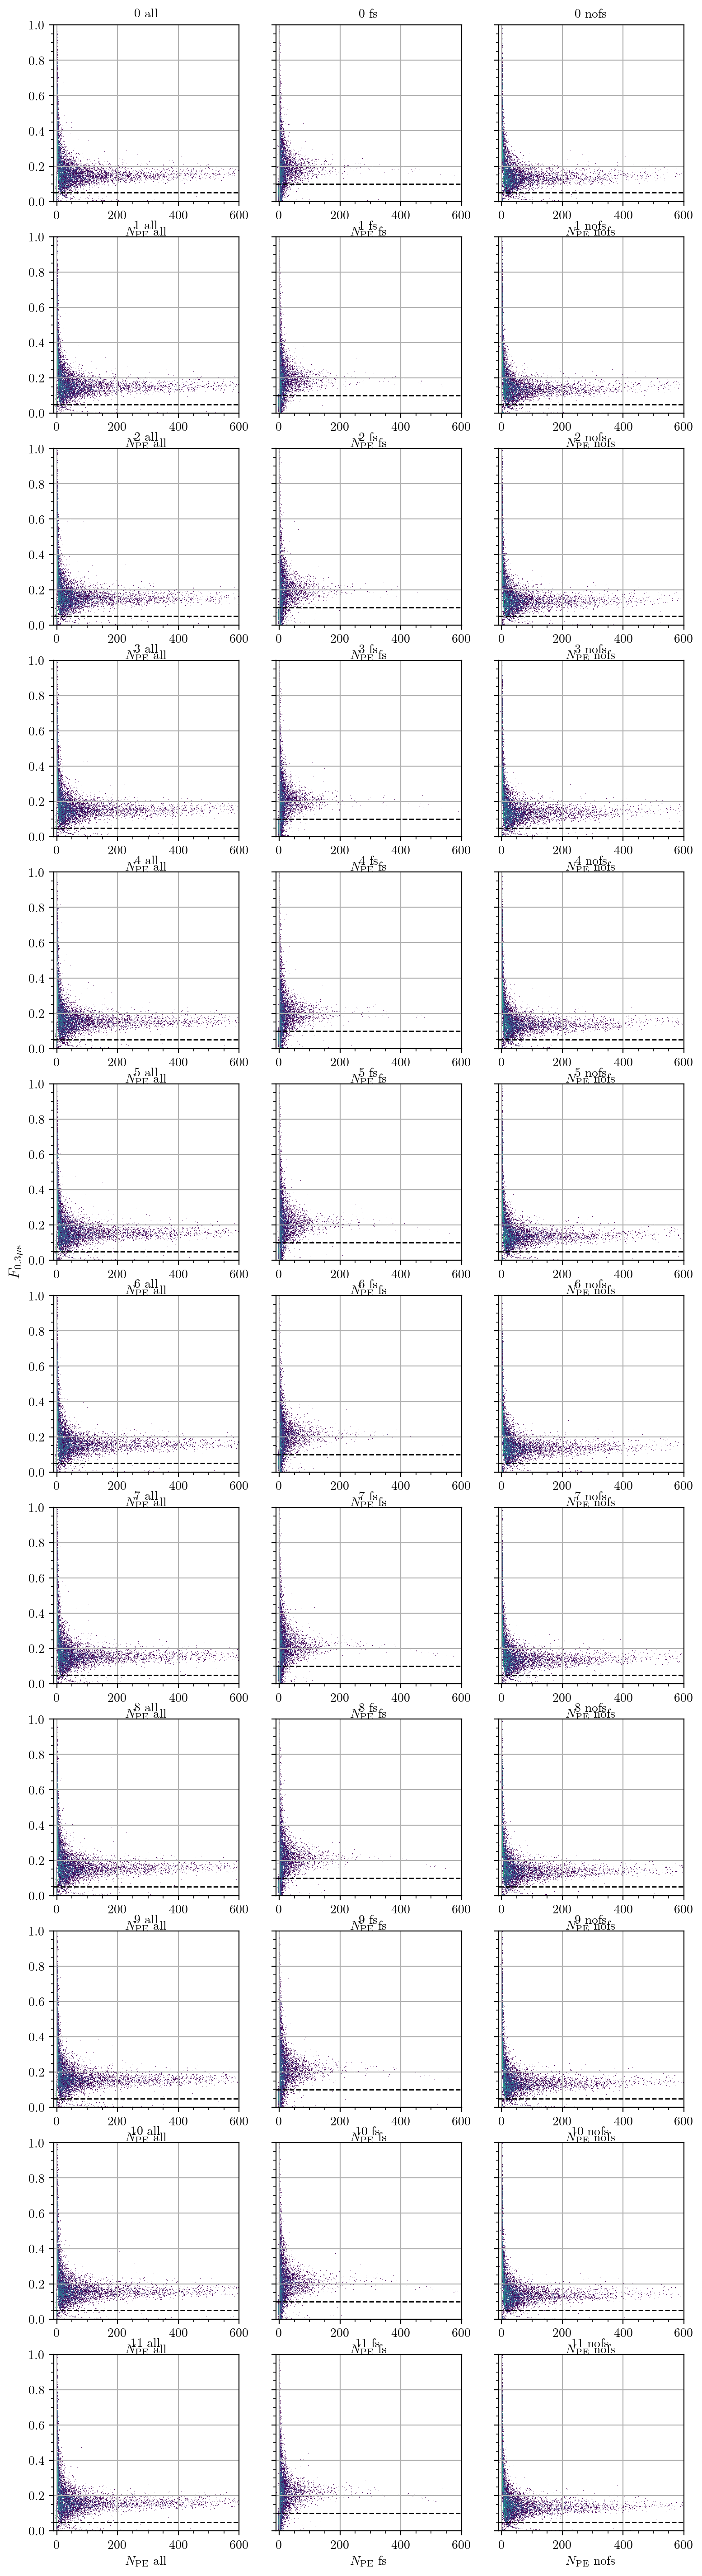

In [32]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(12, 3, sharex=False, sharey=True)
fig.tight_layout(h_pad=5, w_pad=3)
fig.set_size_inches(9, 36)
for i, c in enumerate(cond):
    for j, (p,g) in enumerate(zip(positions,groups)):
        axs[i,j].pcolormesh(*fprompt[c][g])
        axs[i,j].plot([-10,range_maxx],[fp_thre[g]]*2,'k--',linewidth=1)
        axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{c} {p}')
        axs[i,j].set_xlabel(r'$N_{\rm PE}$ ' + p)
fig.supylabel(r'$F_{\rm 0.3\mu s}$', x=0.07)

## Event ID selection

In [85]:
sel = (data[7]['baseline_rms_0']>5) & (data[7]['baseline_rms_1']<2)
ev_id = data[7][sel].index[:10].get_level_values(1).to_numpy()
print(ev_id)
data[7][['baseline_rms_0','baseline_rms_1']][sel]

[ 11  40  88 115 134 138 141 146 153 166]


baseline_rms_0  baseline_rms_1
run event                                
7   11           9.827486        1.352963
    40           6.644573        1.356725
    88           5.059436        1.279501
    115          9.227626        1.270346
    134          6.495001        1.335655
...                   ...             ...
    50294        6.543886        1.284227
    50316        5.563380        1.284393
    50332       36.822865        1.284194
    50336        5.553467        1.298646
    50339       15.321813        1.312148

[3859 rows x 2 columns]

## FS-noFS 2D Distribution

In [33]:
def get_fs_nofs_hist2d(df_data,bsl_filt,fp_filt,sat_filt,bins_xy,range_xy,log_scale):
    filt = np.ones(df_data.shape[0])
    if bsl_filt:
        # filt = filt & df_data['bsl_filt']
        filt = filt & df_data['bsl_filt_1'] & df_data['bsl_filt_2'] & df_data['bsl_filt_4'] & df_data['bsl_filt_7'] 
    if fp_filt:
        filt = filt & df_data['fp_filt_01234567']
    if sat_filt:
        filt = filt & df_data['sat_filt']
    hist2d = list(np.histogram2d(
        df_data['nofs_pe'][filt], 
        df_data['fs_pe'][filt], 
        bins=bins_xy, range=range_xy
    ))
    temp = hist2d[0].T
    hist2d[0], hist2d[1] = np.meshgrid(
        hist2d[1], hist2d[2]
    )
    if log_scale:
        hist2d[2] = np.log10(temp)
    else:
        hist2d[2] = temp
    return hist2d

In [38]:
nbinsx = 500
range_minx = -50
range_maxx = 1000
nbinsy = 500
range_miny = -50
range_maxy = 500

top_bot_pe = {}
for c in cond:
    top_bot_pe[c] = {}
    # top_bot_pe[c]['counts'], top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.histogram2d(
    #     data[c]['nofs_pe'][data[c]['all_filt']], 
    #     data[c]['fs_pe'][data[c]['all_filt']], 
    #     bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    # )
    bsl_filt = data[c]['bsl_filt_1'] & data[c]['bsl_filt_2'] & data[c]['bsl_filt_4'] & data[c]['bsl_filt_7'] 
    top_bot_pe[c]['counts'], top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.histogram2d(
        data[c]['nofs_pe'][bsl_filt & data[c]['fp_filt_01234567']], 
        data[c]['fs_pe'][bsl_filt & data[c]['fp_filt_01234567']], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    top_bot_pe[c]['counts'] = top_bot_pe[c]['counts'].T
    top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins'] = np.meshgrid(
        top_bot_pe[c]['xbins'], top_bot_pe[c]['ybins']
    )

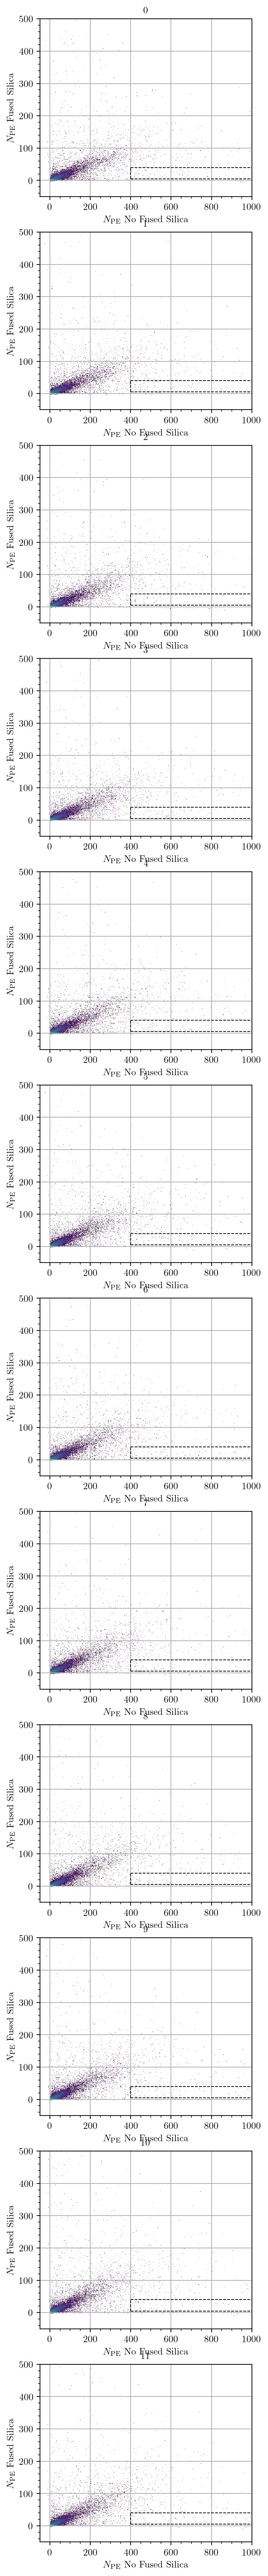

In [39]:
fig, axs = plt.subplots(12, 1, sharex=False, sharey=False)
fig.set_size_inches(4,48)
x1, y1, x2, y2 = 400, 5, 1000, 40
for i, c in enumerate(cond):
    axs[i].pcolormesh(
        top_bot_pe[c]['xbins'],
        top_bot_pe[c]['ybins'],
        np.log10(top_bot_pe[c]['counts'])
    )
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
    axs[i].set_xlim(-50, 1000)
    axs[i].set_ylim(-50, 500)
    axs[i].set_xlabel(r'$N_{\rm PE}$ No Fused Silica')
    axs[i].set_ylabel(r'$N_{\rm PE}$ Fused Silica')
    axs[i].plot([x1,x1], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x2,x2], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y1,y1], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y2,y2], 'k--', linewidth=0.8)
    # x_sat = np.linspace(0,1000,10)
    # y_sat = -0.02*x_sat
    # axs[i].plot(x_sat, y_sat, 'r--', linewidth=0.8)

# mask_x, mask_y = (top_bot_pe[c]['xbins'][0,1:]<x2)&(top_bot_pe[c]['xbins'][0,1:]>x1), (top_bot_pe[c]['ybins'][1:,0]<y2)&(top_bot_pe[c]['ybins'][1:,0]>y1)
# bkg_scale = {}
# for c in cond[:-1]:
#     bkg_scale[c] = np.sum(top_bot_pe[c]['counts'][mask_y][:,mask_x])/np.sum(top_bot_pe['Backgrounds']['counts'][mask_y][:,mask_x])
#     print(f'Backgrounds to be scaled by {bkg_scale[c]} in {c} data')

## Lost charge correction

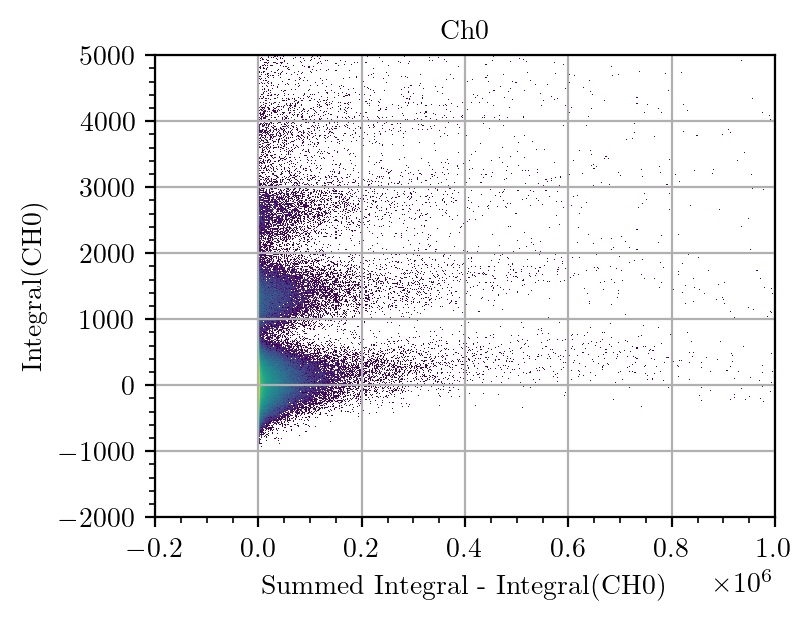

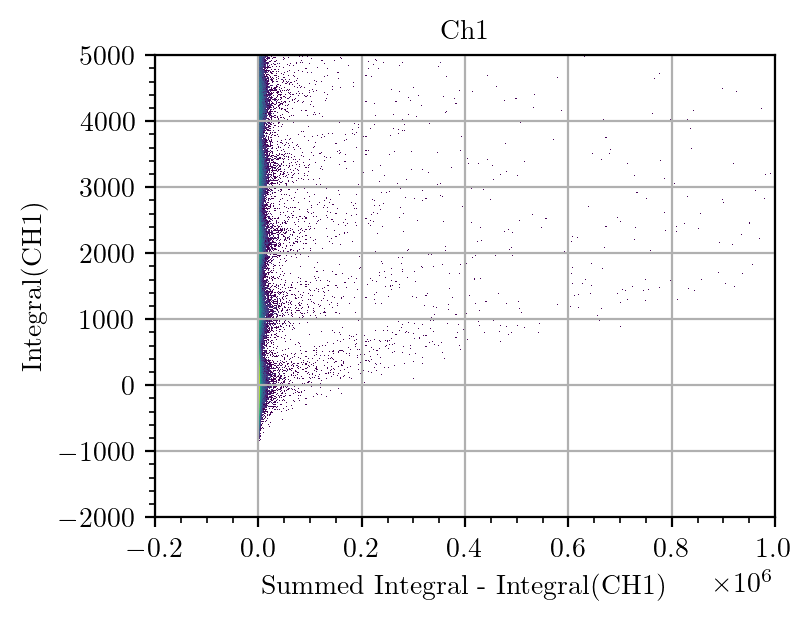

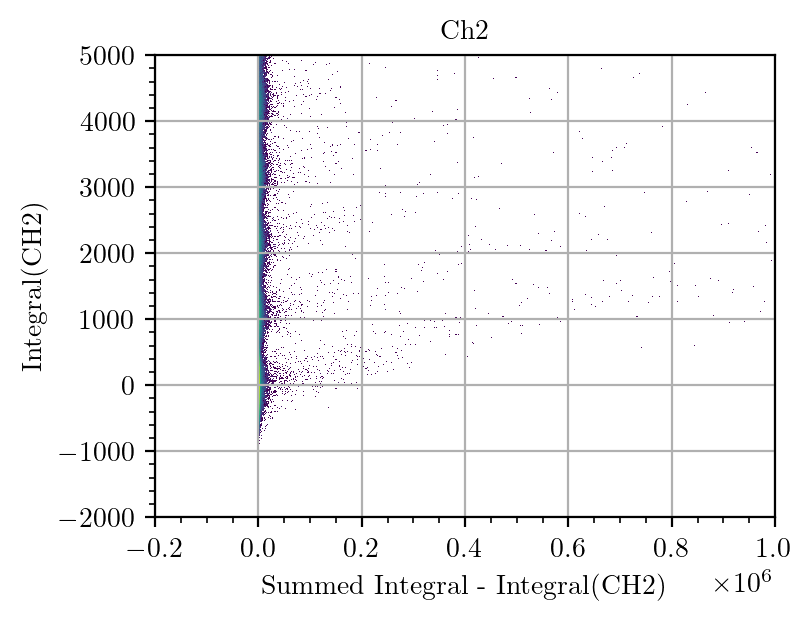

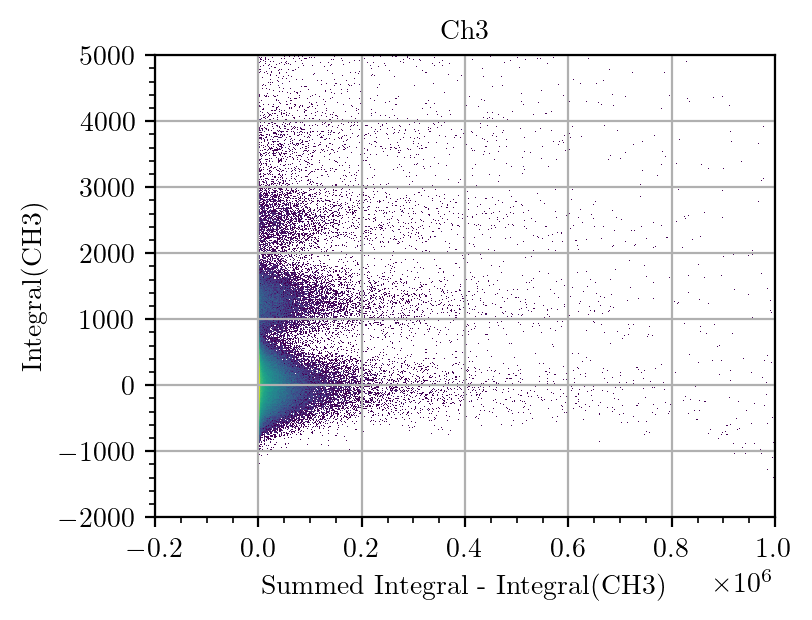

In [25]:
# r = -1.77e-2
# mat = np.ones((4,4))*r + np.eye(4)*(1-r)
# mat = np.linalg.inv(mat)

# c = 'Co-60'
# intg = 'integral_5p00us_'
# cut = data[c]['bsl_filt'] & data[c]['fp_filt']
# orig_int_bot = pd.concat([data[c][f'{intg}0'][cut],data[c][f'{intg}1'][cut],data[c][f'{intg}2'][cut],data[c][f'{intg}3'][cut]],axis=1)
# new_int_bot = orig_int_bot @ mat

# for i in range(4):
#     z, xb, yb = np.histogram2d(
#         new_int_bot.sum(axis=1)-new_int_bot[i], 
#         new_int_bot[i],
#         bins=[500,500],
#         range=[[-1e3,1e6],[-1.5e3,5e3]]
#     )
#     z = z.T
#     xb,yb = np.meshgrid(
#         xb,yb
#     )
#     plt.figure(i)
#     plt.pcolormesh(xb,yb,np.log10(z))
#     plt.grid()
#     plt.minorticks_on()
#     plt.title(f'Ch{i}')
#     plt.xlabel(f'Summed Integral - Integral(CH{i})')
#     plt.ylabel(f'Integral(CH{i})')

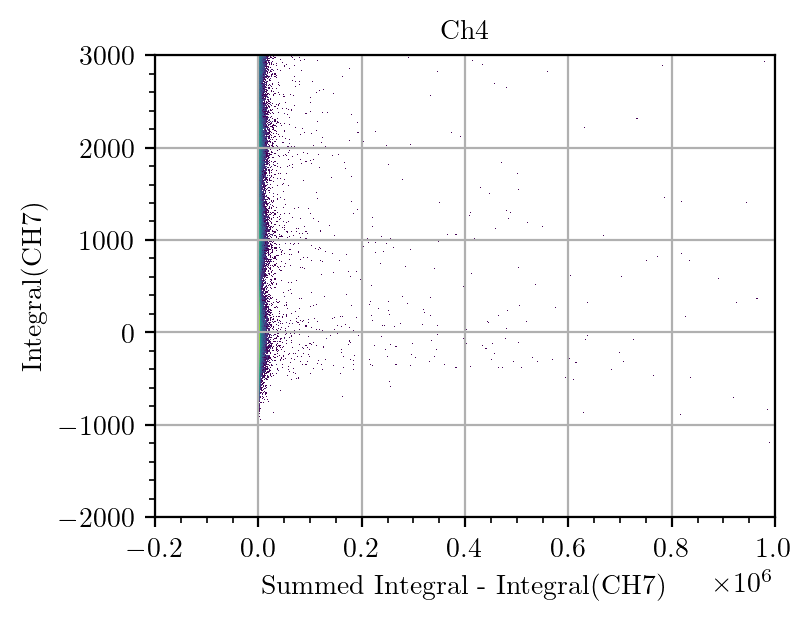

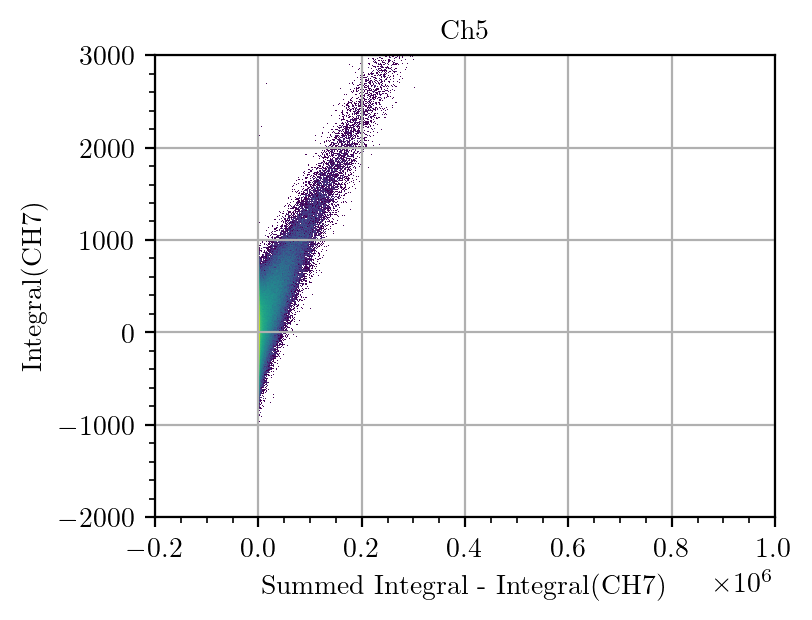

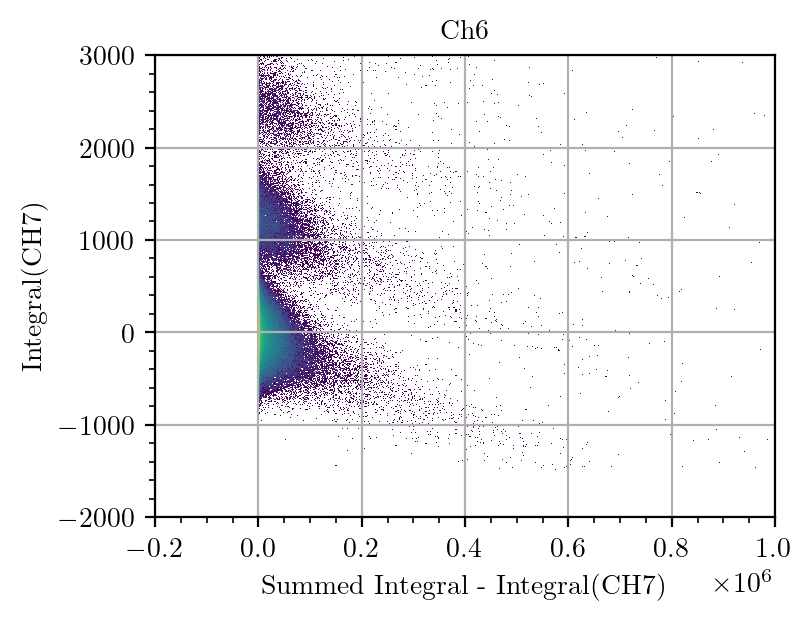

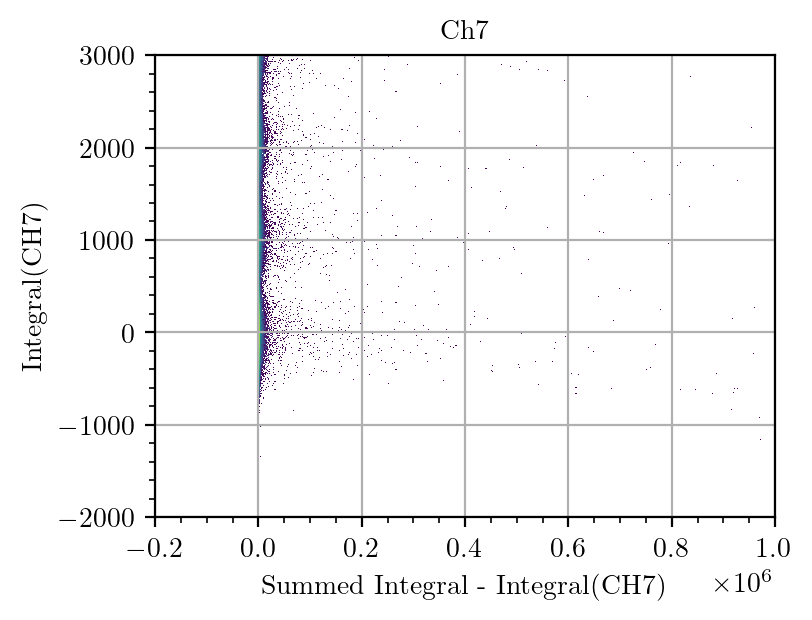

In [26]:
# r = -1.2e-2
# mat = np.ones((4,4))*r + np.eye(4)*(1-r)
# mat = np.linalg.inv(mat)

# c = 'Co-60'
# intg = 'integral_5p00us_'
# cut = data[c]['bsl_filt'] & data[c]['fp_filt']
# orig_int_top = pd.concat([data[c][f'{intg}4'][cut],data[c][f'{intg}5'][cut],data[c][f'{intg}6'][cut],data[c][f'{intg}7'][cut]],axis=1)
# new_int_top = orig_int_top @ mat

# for i in range(4,8):
#     z, xb, yb = np.histogram2d(
#         new_int_top.sum(axis=1)-new_int_top[i-4], 
#         new_int_top[i-4],
#         bins=[500,500],
#         range=[[-1e3,1e6],[-1.5e3,3e3]]
#     )
#     z = z.T
#     xb,yb = np.meshgrid(
#         xb,yb
#     )
#     plt.figure(i)
#     plt.pcolormesh(xb,yb,np.log10(z))
#     plt.grid()
#     plt.minorticks_on()
#     plt.title(f'Ch{i}')
#     plt.xlabel(f'Summed Integral - Integral(CH{ch})')
#     plt.ylabel(f'Integral(CH{ch})')

## Channel-by-channel comparison

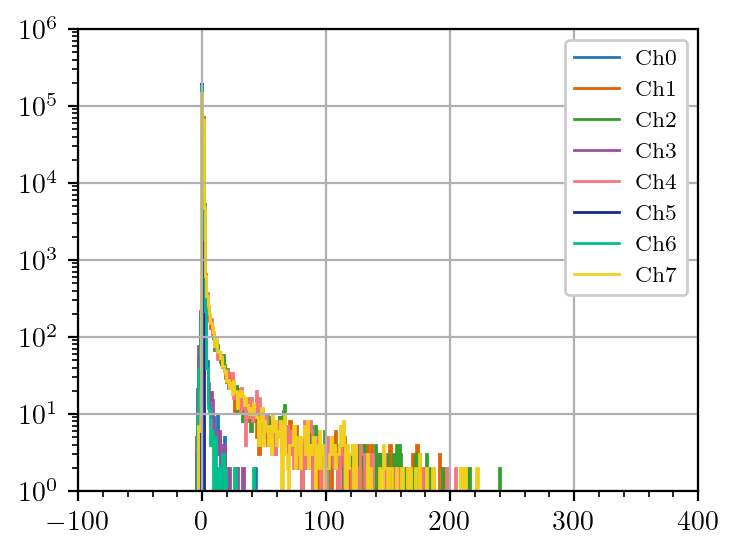

In [27]:
# c = 'Backgrounds'
# for i in range(8):
#     hist,bins = np.histogram(data[c][data[c]['all_filt']][f'integral_5p00us_{i}']/convert_pe[i],bins=np.linspace(-30,400,400));
#     plt.stairs(hist,bins,label=f'Ch{i}')
# plt.yscale('log')
# plt.grid()
# plt.minorticks_on()
# plt.legend(loc='upper right')

## Cut selection effects

Text(0, 0.5, 'Events')

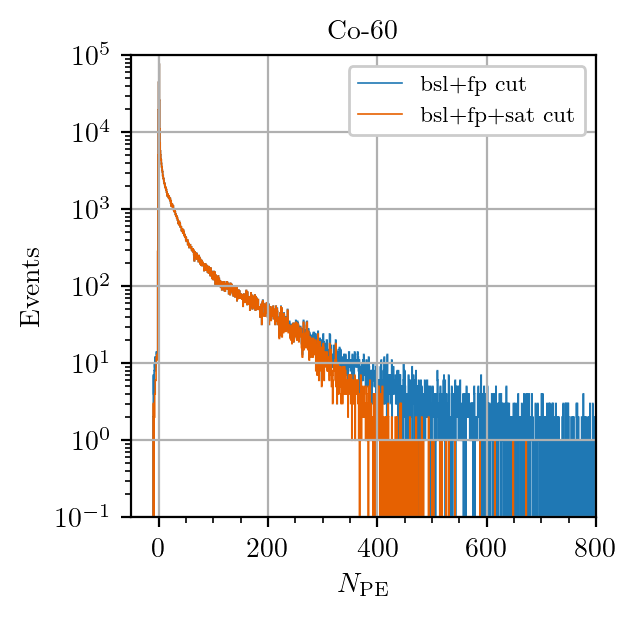

In [48]:
# c = 'Co-60'
# filt1 = data[c]['bsl_filt'] & data[c]['fp_filt']
# filt2 = filt1 & data[c]['sat_filt']
# # hist0 = np.histogram(data[c]['nofs_pe'],bins=4000,range=(-10,2000))
# hist1 = np.histogram(data[c]['nofs_pe'][filt1],bins=4000,range=(-10,2000))
# hist2 = np.histogram(data[c]['nofs_pe'][filt2],bins=4000,range=(-10,2000))
# # hist3 = np.histogram(data[c]['nofs_pe'][filt3],bins=4000,range=(-10,2000))
# plt.figure(0,figsize=(3,3))
# # plt.stairs(*hist0,label='no cut',linewidth=0.6)
# plt.stairs(*hist1,label='bsl+fp cut',linewidth=0.6)
# plt.stairs(*hist2,label='bsl+fp+sat cut',linewidth=0.6)
# # plt.stairs(*hist3,label='bsl+sat+fp cut',linewidth=0.6)
# plt.yscale('log')
# plt.legend(loc='upper right')
# plt.grid()
# plt.minorticks_on()
# plt.xlim(-50,800)
# plt.ylim(1e-1,1e5)
# plt.title('Co-60')
# plt.xlabel(r'$N_{\rm PE}$')
# plt.ylabel('Events')

## Background subtraction

In [40]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [41]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        # spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
        #     data[c]['nofs_pe'][data[c]['all_filt']] if w=='no' else data[c]['fs_pe'][data[c]['all_filt']], 
        #     bins=nbins, range=(range_min, range_max)
        # )
        bsl_filt = data[c]['bsl_filt_1'] & data[c]['bsl_filt_2'] & data[c]['bsl_filt_4'] & data[c]['bsl_filt_7'] 
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data[c]['nofs_pe'][bsl_filt & data[c]['fp_filt_01234567']] if w=='no' else data[c]['fs_pe'][bsl_filt & data[c]['fp_filt_01234567']], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])
# for c in cond[:-1]:
#     spectra[c][w]['counts'] = spectra[c][w]['counts'] - spectra['Backgrounds'][w]['counts']*bkg_scale[c]
#     spectra[c][w]['errs'] = (spectra[c][w]['errs']**2 + (spectra['Backgrounds'][w]['errs']*bkg_scale[c])**2)**0.5

In [71]:
# c = cond[1]
# filt1 = data[c]['bsl_filt']
# filt2 = filt1 & data[c]['sat_filt']
# filt3 = filt2 & data[c]['fp_filt']
# hist0 = np.histogram(data[c]['top_pe'],bins=4000,range=(-10,2000))
# hist1 = np.histogram(data[c]['top_pe'][filt1],bins=4000,range=(-10,2000))
# hist2 = np.histogram(data[c]['top_pe'][filt2],bins=4000,range=(-10,2000))
# hist3 = np.histogram(data[c]['top_pe'][filt3],bins=4000,range=(-10,2000))
# plt.stairs(*hist0,label='no cut',linewidth=0.6)
# plt.stairs(*hist1,label='bsl cut',linewidth=0.6)
# plt.stairs(*hist2,label='bsl+sat cut',linewidth=0.6)
# plt.stairs(*hist3,label='bsl+sat+fp cut',linewidth=0.6)
# plt.yscale('log')
# plt.legend()
# plt.grid()
# plt.minorticks_on()

Text(0.06, 0.5, 'Events')

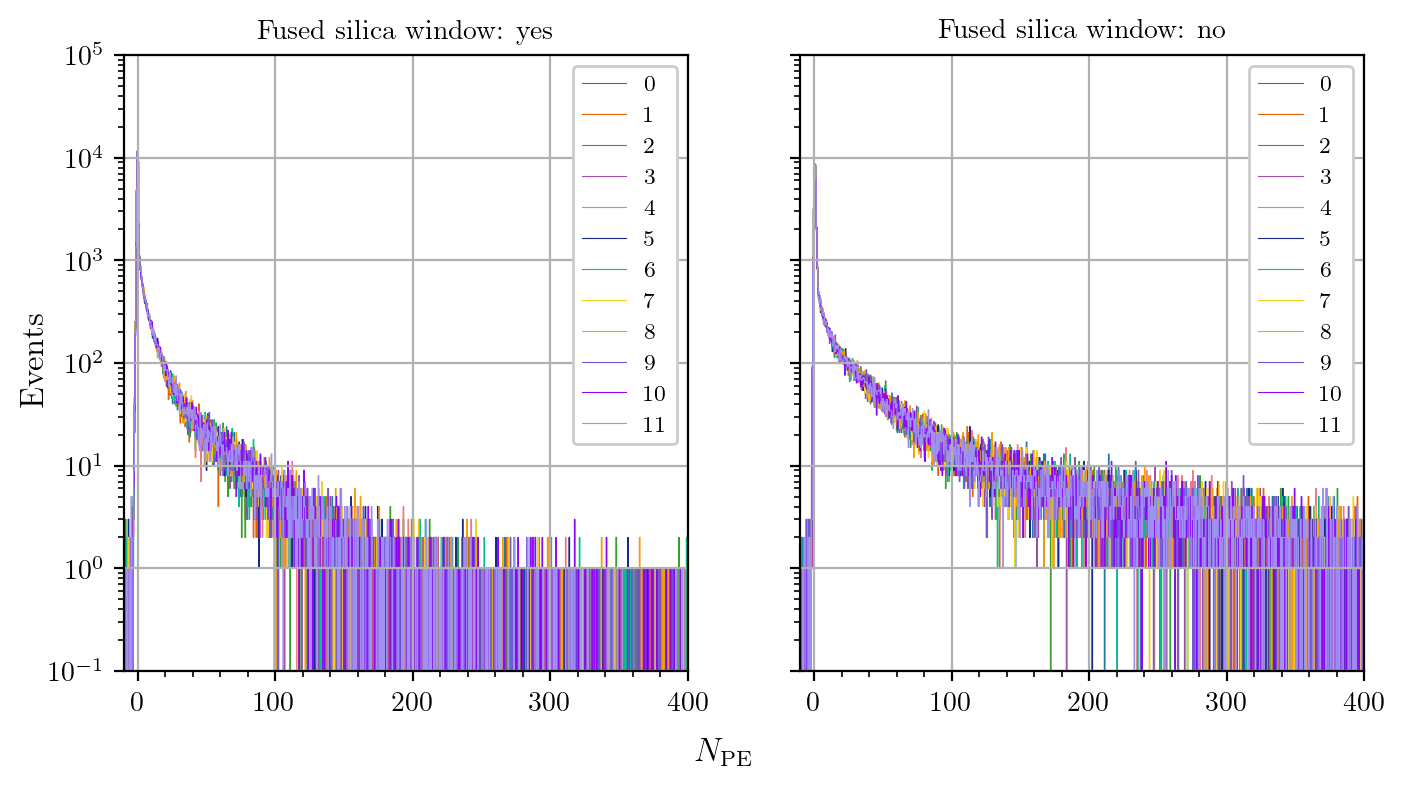

In [42]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(8, 4)
for j, w in enumerate(window):
    # for i, c in enumerate(cond[:-1]):
    for i, c in enumerate(cond):
        axs[j].stairs(
            spectra[c][w]['counts'], 
            spectra[c][w]['bins'], 
            label=f'{c}', color=f'C{i}', linewidth=0.4
        )
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-1, 1e5)
    axs[j].set_xlim(-10, 400)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.01)
fig.supylabel('Events', x=0.06)

## G4DS simulation (Compton scattering + UV photon transport)

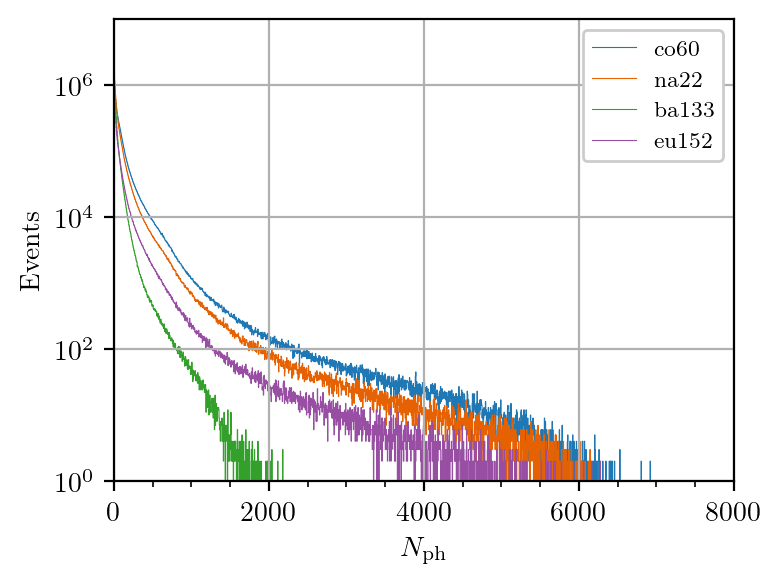

In [43]:
src = {'Co-60':'co60','Na-22':'na22','Ba-133':'ba133','Eu-152':'eu152'}
hist_sim = {}
for s in src.values():
    rtf = uproot.open(f'data/pe_hist/no_reflection/pu_lar_{s}_hist.root')
    hist_sim[s] = rtf['nph_nofs_1247'].to_numpy()
    plt.stairs(hist_sim[s][0],hist_sim[s][1],linewidth=0.4,label=s)
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$N_{\rm ph}$')
plt.ylabel('Events')
plt.legend(loc='upper right')

## Detector response model
The number of PE follows the distribution
$$N_{\rm PE} \sim \mathcal{N}(\mu=N_{\rm ph}\times\varepsilon_p S_y/S_y^0, \sigma=\sqrt{F\mu + \alpha^2 \mu^2}),$$
where $N_{\rm ph}$ is the number of photons arriving at the SiPMs (from G4DS), $\varepsilon_p$ is the SiPMs' photo-detection efficiency (PDE), $S_y^0$ is the nominal (maximum) LAr scintillation yield $1ph/19.5eV=51.3ph/keV$ (default in G4DS), $S_y$ is the true scintillation yield ($\approx 40ph/keV$ for LAr), $F$ is the Fano factor of the SiPMs due to correlated avalanches, and $\alpha$ is a smearing factor accounting for scintillation directionality.

In [44]:
class DetectorSmearing():
    def __init__(self, fano, hist_in):
        self.hist_in_bin = hist_in[1]
        self.hist_in_width = self.hist_in_bin[1]-self.hist_in_bin[0]
        self.hist_in_count = hist_in[0]/np.sum(hist_in[0])/self.hist_in_width # normalized
        self.fano = fano

    def response_matrix(self, pe_in, pe_out, pde):
        pe_det = pde*pe_in
        smear2 = 0
        return norm.pdf(pe_out, loc=pe_det, scale=np.sqrt(self.fano*pe_det + smear2**2*pe_det**2))

    def get_spectrum(self, bins, n, pde):
        self.hist_out_bin = bins
        bin_cen_in = (self.hist_in_bin[1:]+self.hist_in_bin[:-1])/2
        bin_cen_out = (self.hist_out_bin[1:]+self.hist_out_bin[:-1])/2
        pe_out_mesh, pe_in_mesh = np.meshgrid(bin_cen_out, bin_cen_in)
        self.hist_out_count = self.hist_in_count @ self.response_matrix(pe_in_mesh, pe_out_mesh, pde)
        return n*self.hist_out_count, self.hist_out_bin
        
    def fit_to_data(self, data, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            n, pde = x[0], x[1]
            data_y, data_bin = args[0], args[1]
            bincen = (data_bin[1:] + data_bin[:-1])/2
            ans = (data_y-self.get_spectrum(data_bin, n, pde)[0])
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (bincen<fit_range[1]) & (bincen>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data,bounds=(0,np.inf))
        return res.x
        

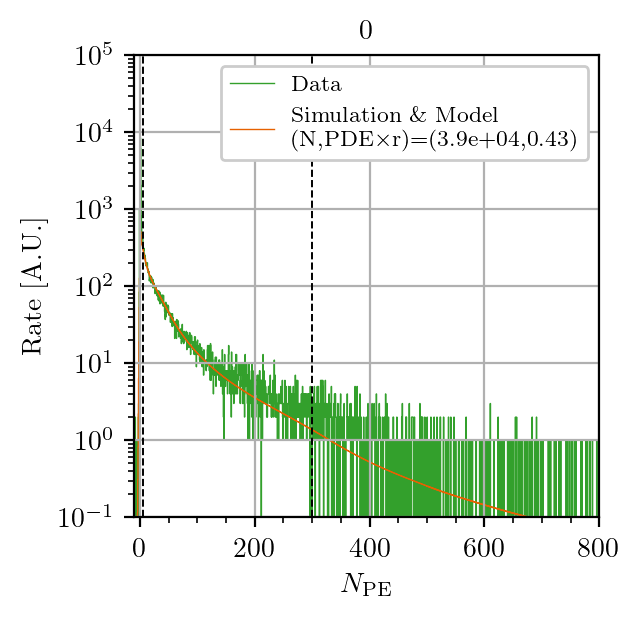

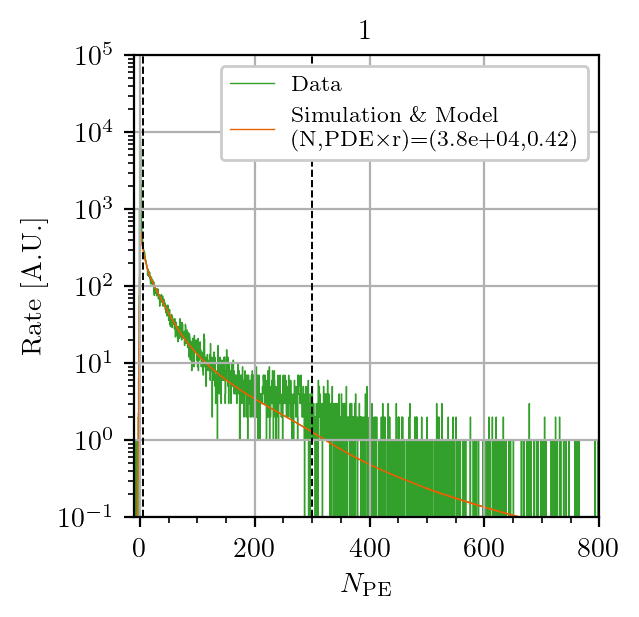

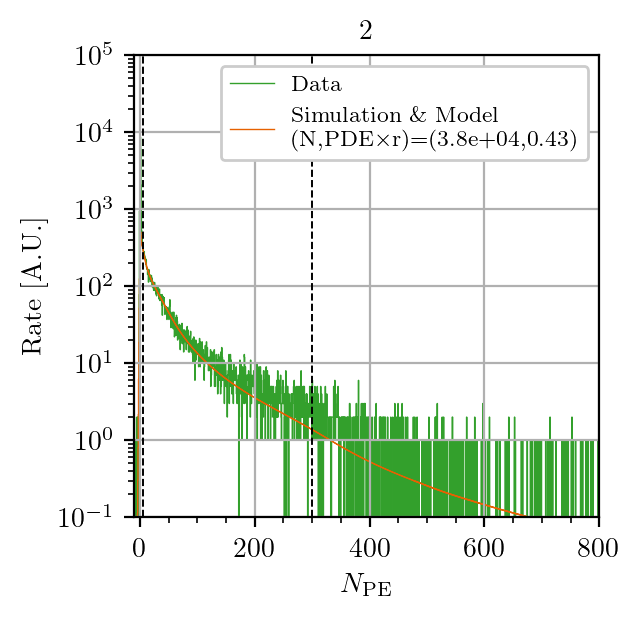

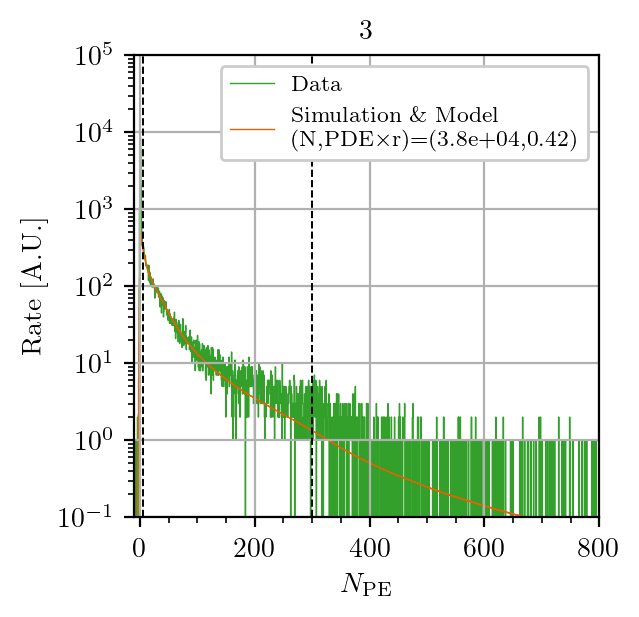

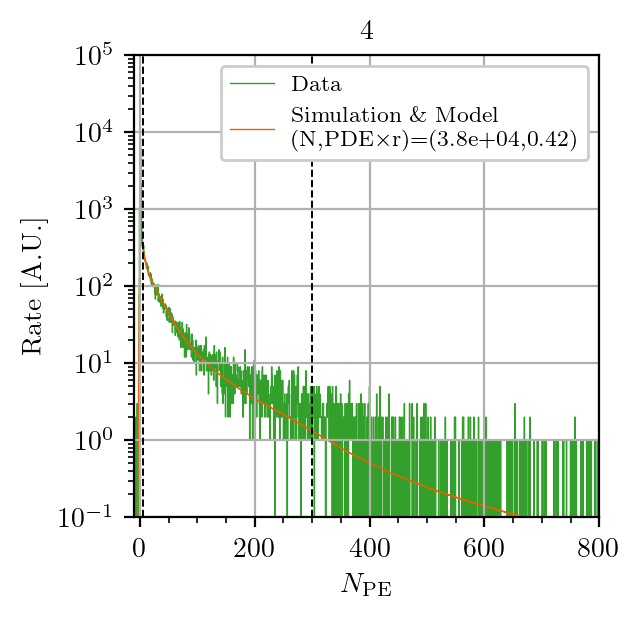

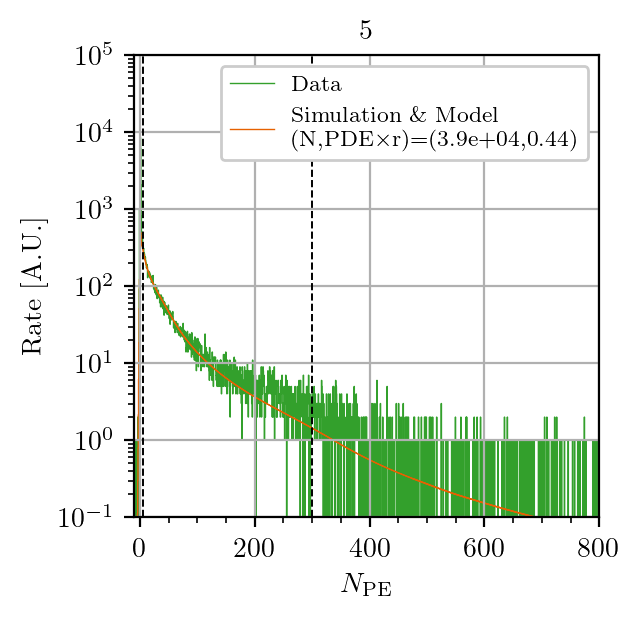

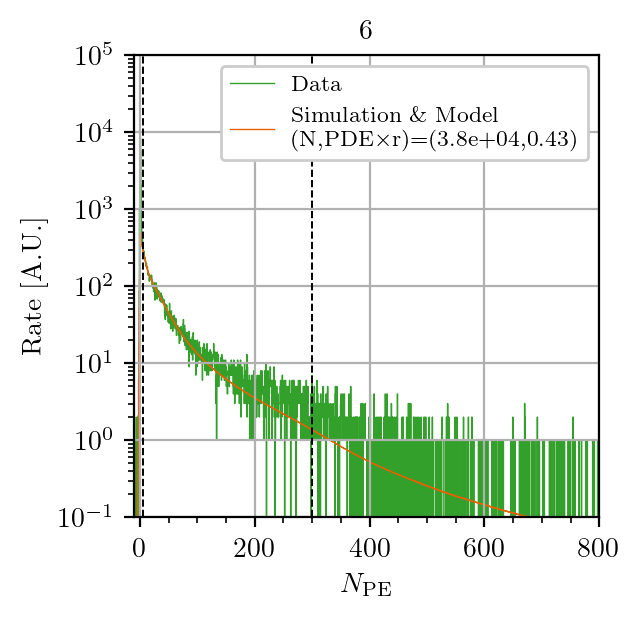

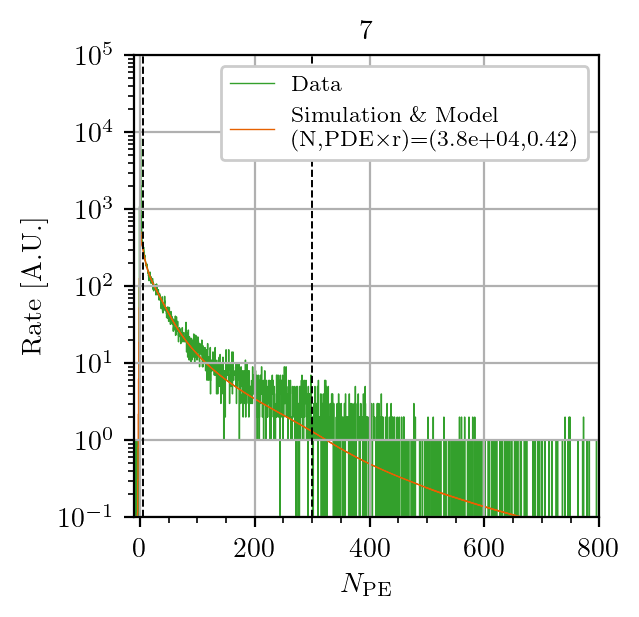

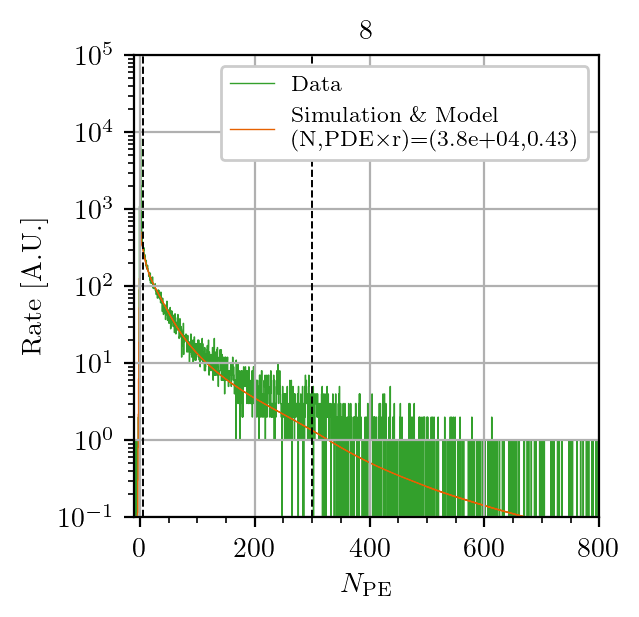

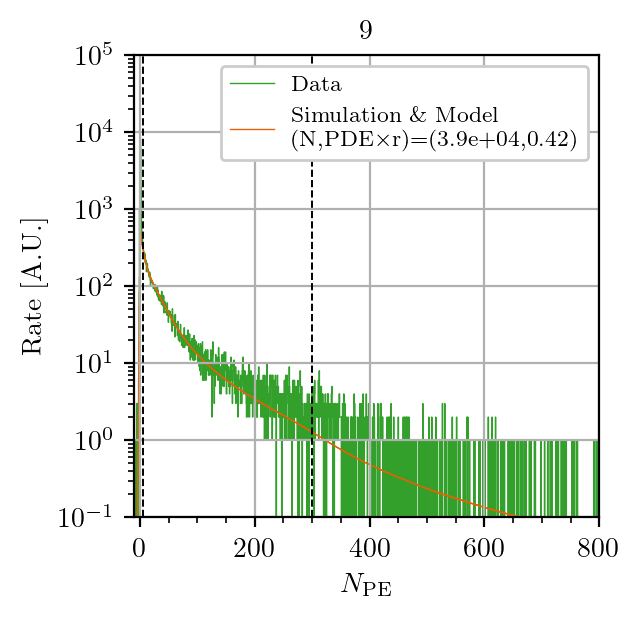

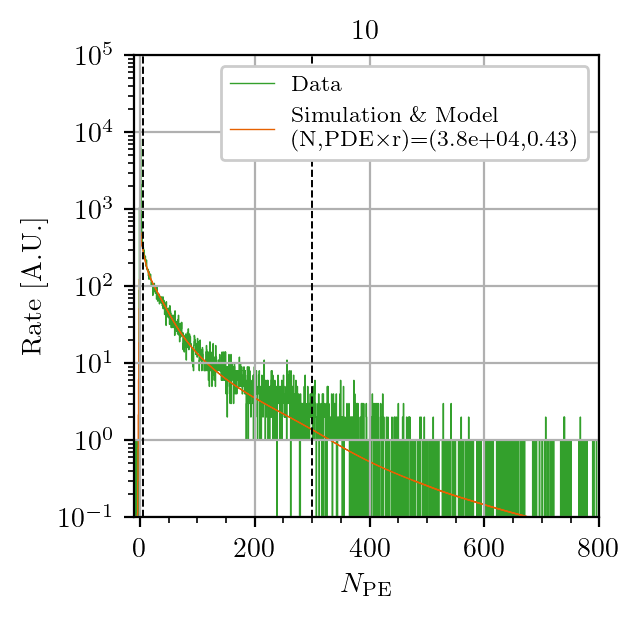

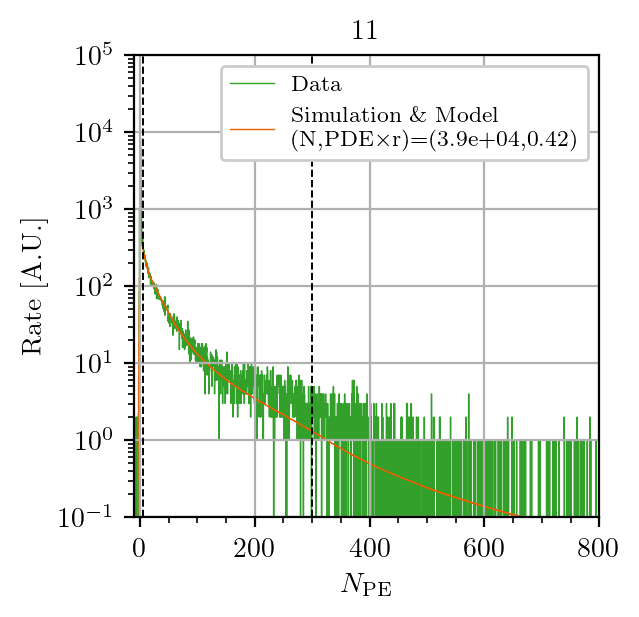

In [45]:
# for i,c in enumerate(cond[:-1]):
for i,c in enumerate(cond):
    plt.figure(i,figsize=(3,3))
    fit_range = (5,300)
    ymin, ymax = 1e-1,1e8
    # smear = DetectorSmearing(fano=1.06,hist_in=hist_sim[src[c]])
    smear = DetectorSmearing(fano=1.06,hist_in=hist_sim['co60'])
    par = smear.fit_to_data(
        data=(spectra[c]['no']['counts'],spectra[c]['no']['bins']),
        sigma=spectra[c]['no']['errs'],
        x0=[5e5,0.3*4/5],
        fit_range=fit_range
    )
    # par = [8e5,0.1,0.55*4/5]
    plt.stairs(spectra[c]['no']['counts'],spectra[c]['no']['bins'], label='Data', color='C2', linewidth=0.5)
    plt.stairs(*(smear.get_spectrum(spectra[c]['no']['bins'],*par)), label='Simulation \& Model\n'+r'(N,PDE$\times$r)='+f'({par[0]:.1e},{par[1]:.2f})', color='C1', linewidth=0.5)
    plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.ylim(1e-1,1e5)
    plt.xlim(-10,800)
    plt.legend(loc='upper right')
    plt.title(c)
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Rate [A.U.]')

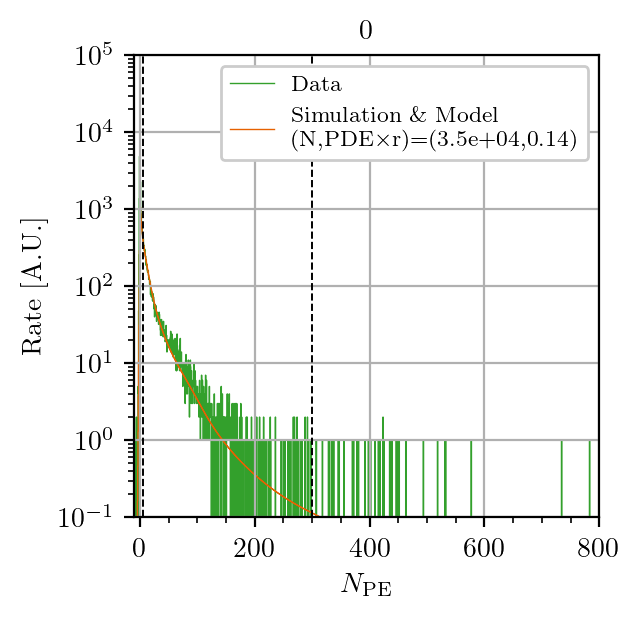

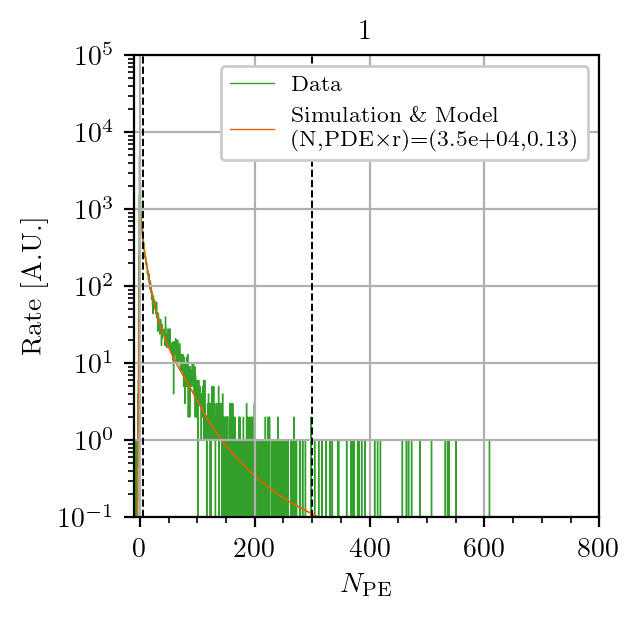

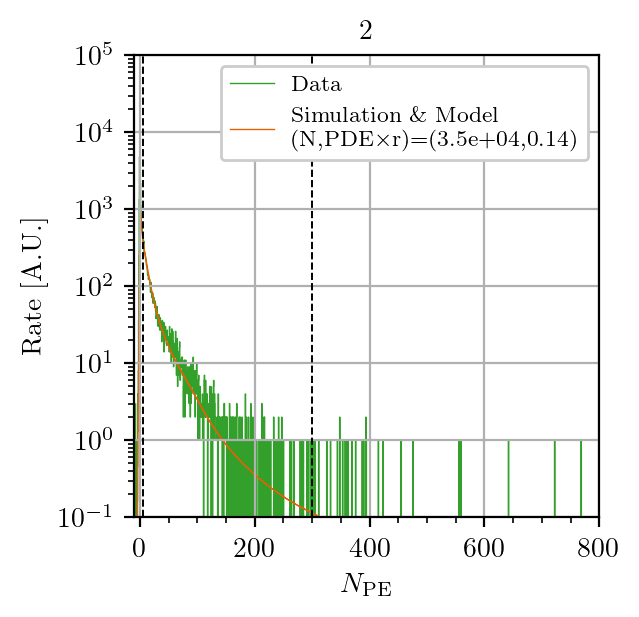

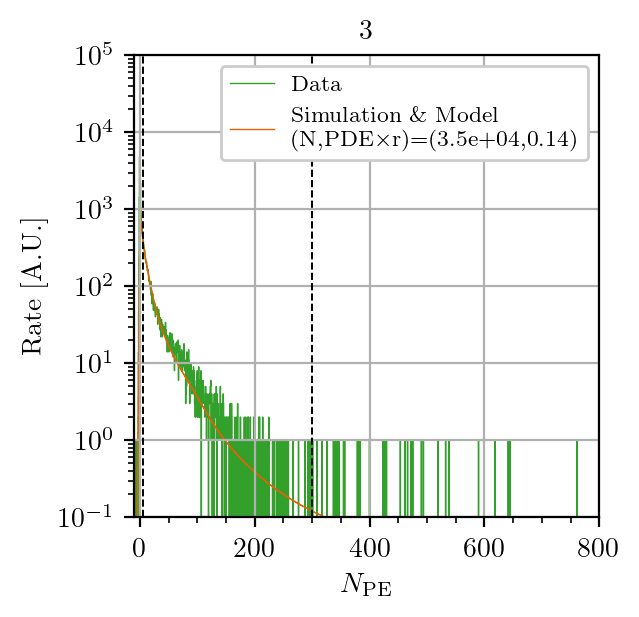

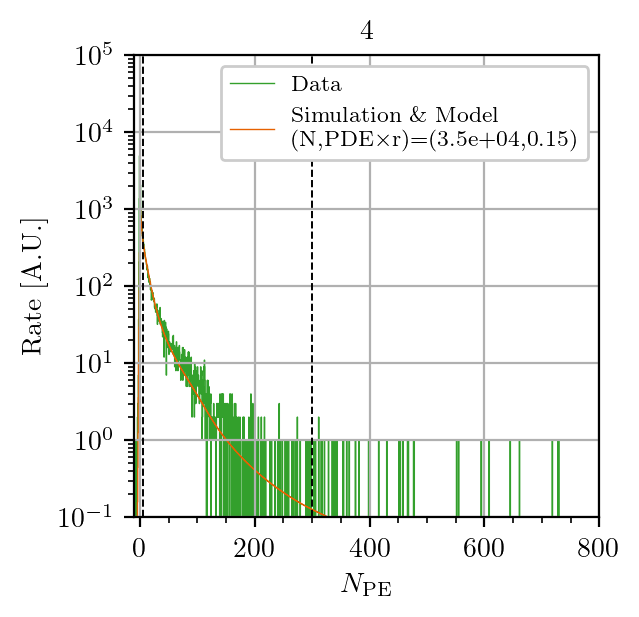

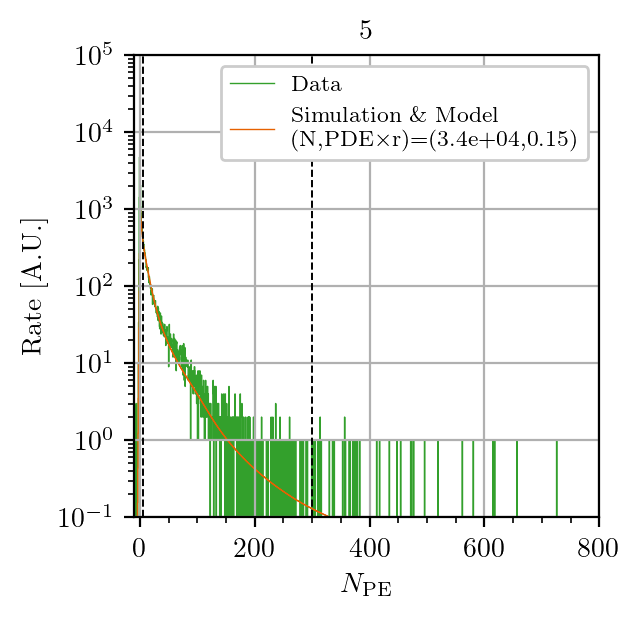

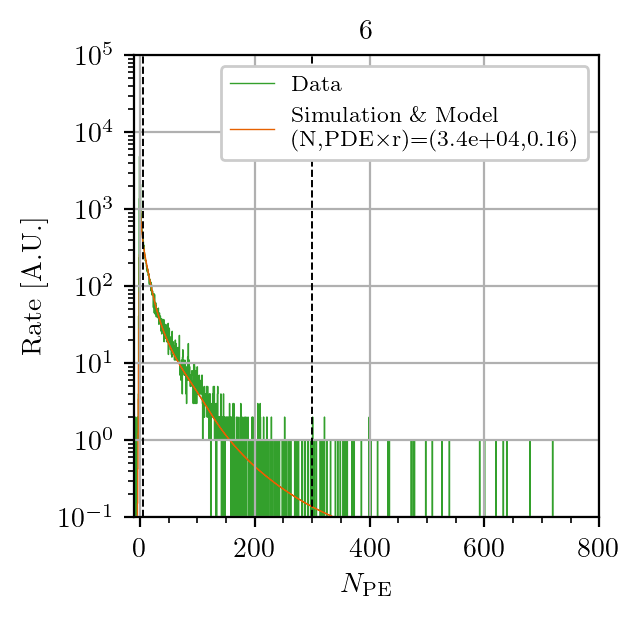

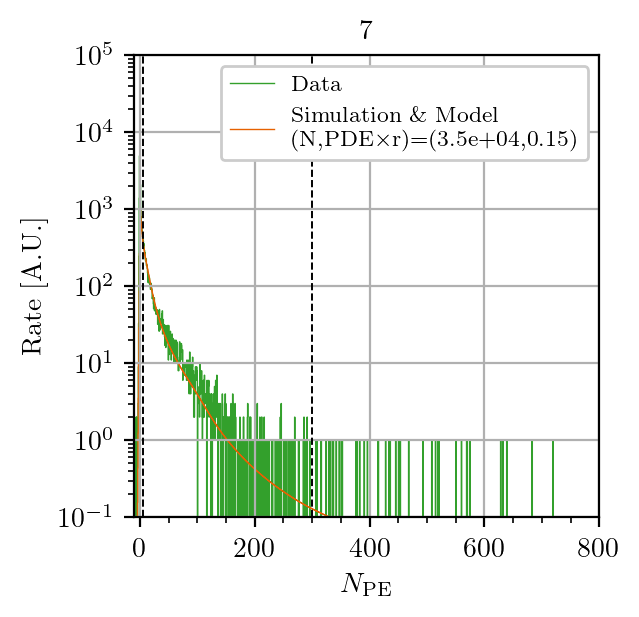

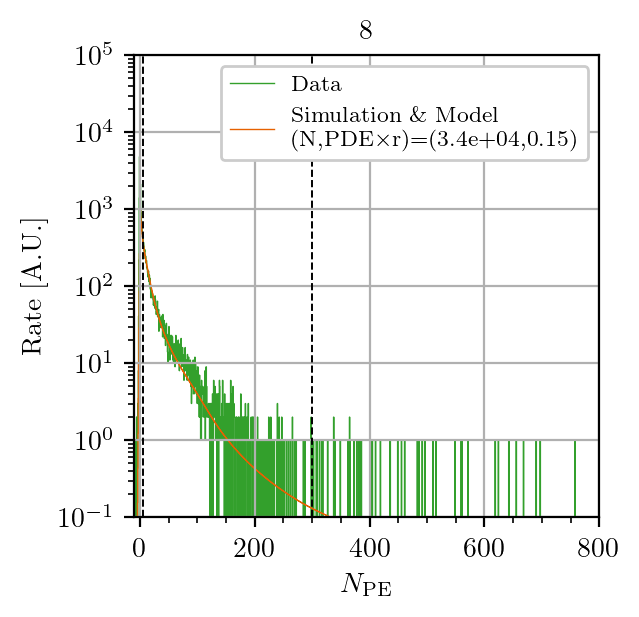

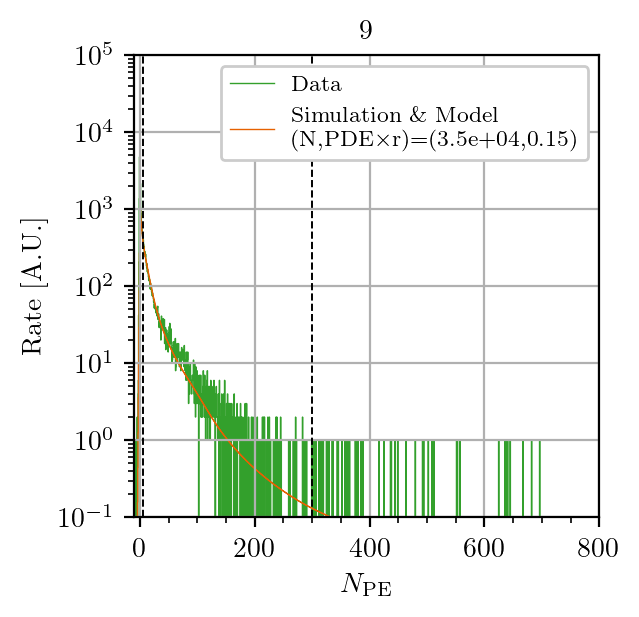

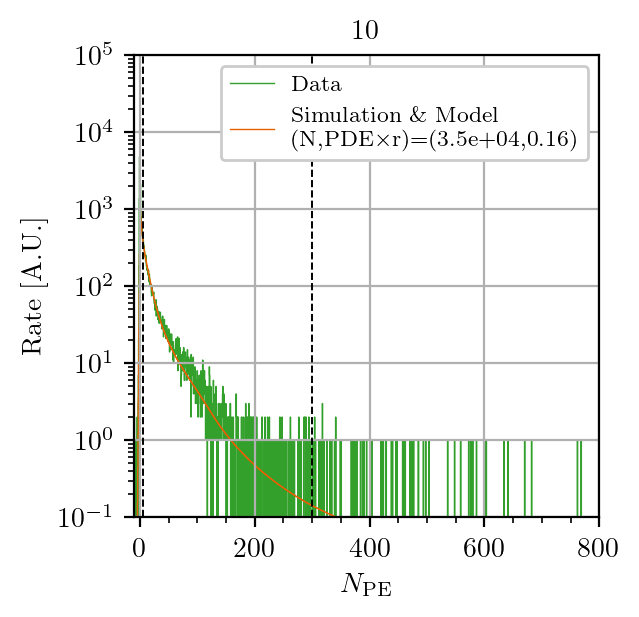

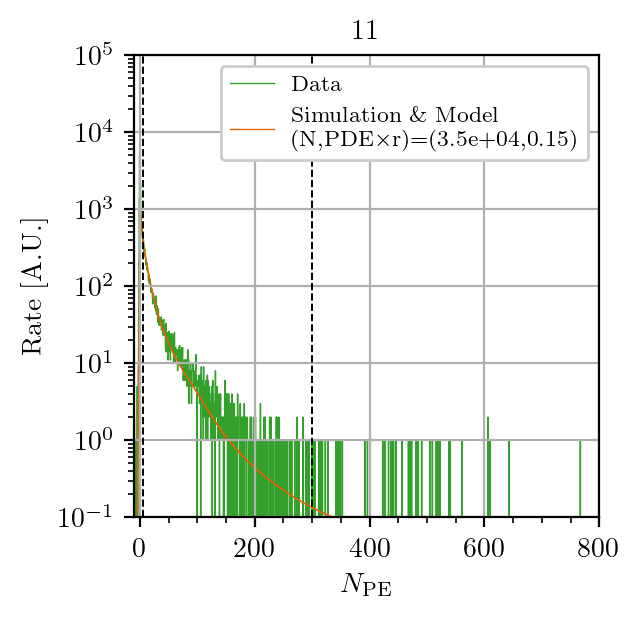

In [46]:
# for i,c in enumerate(cond[:-1]):
for i,c in enumerate(cond):
    plt.figure(i,figsize=(3,3))
    fit_range = (5,300)
    ymin, ymax = 1e-1,1e8
    # smear = DetectorSmearing(fano=1.06,hist_in=hist_sim[src[c]])
    smear = DetectorSmearing(fano=1.06,hist_in=hist_sim['co60'])
    par = smear.fit_to_data(
        data=(spectra[c]['yes']['counts'],spectra[c]['yes']['bins']),
        sigma=spectra[c]['yes']['errs'],
        x0=[5e5,0.1*4/5],
        fit_range=fit_range
    )
    # par = [8e5,0.1,0.55*4/5]
    plt.stairs(spectra[c]['yes']['counts'],spectra[c]['yes']['bins'], label='Data', color='C2', linewidth=0.5)
    plt.stairs(*(smear.get_spectrum(spectra[c]['yes']['bins'],*par)), label='Simulation \& Model\n'+r'(N,PDE$\times$r)='+f'({par[0]:.1e},{par[1]:.2f})', color='C1', linewidth=0.5)
    plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.ylim(1e-1,1e5)
    plt.xlim(-10,800)
    plt.legend(loc='upper right')
    plt.title(c)
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Rate [A.U.]')

# Co-60 at different over-voltages

In [2]:
path = "/scratch/gpfs/as111/results/"
date = '2024-02-26'
files = [[],[],[],[],[]] # 92V, 94V, 96V, 98V, 100V
files[0].extend(glob(f"{path}{date}/*volt_92*scintillation_pulse_liq6.h5"))
files[1].extend(glob(f"{path}{date}/*volt_94*scintillation_pulse_liq6.h5"))
files[2].extend(glob(f"{path}{date}/*volt_96*scintillation_pulse_liq6.h5"))
files[3].extend(glob(f"{path}{date}/*volt_98*scintillation_pulse_liq6.h5"))
files[4].extend(glob(f"{path}{date}/*volt_100*scintillation_pulse_liq6.h5"))
print(len(files[0]), files[0])
print(len(files[1]), files[1])
print(len(files[2]), files[2])
print(len(files[3]), files[3])
print(len(files[4]), files[4])

10 ['/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run8_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run6_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run3_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run4_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run7_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run2_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-26/2024-02-26_volt_92_light_scintillation_cond_gamma_source_co60_run0_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-

In [3]:
# data folder
data = {}
date_time = {}
channels = np.arange(-1,8) # channel -1 contains total_pe and fprompt
volts = [92,94,96,98,100]
cond = ['92V','94V','96V','98V','100V']
for i, c in enumerate(cond):
    volt = volts[i]
    if len(files[i])>0:
        data[c] = {}
        for ch in channels:
            data[c][ch] = []
            for f in files[i]:
                df = pd.read_hdf(f, key=f'{volt}/{ch}')
                data[c][ch].append(df)
                df = None
            data[c][ch] = pd.concat(data[c][ch]).sort_index()
            if ch!=-1:
                data[c][ch].rename(columns=lambda x: x+f'_{ch}',inplace=True)
        data[c] = pd.concat(list(data[c].values()),axis=1)
    print(f'{data[c].shape[0]} {c} events')
# print(f'{data[cond[1]].shape[0]} background events')
print('columns: ', list(data[cond[0]].columns))

503373 92V events
503577 94V events
503698 96V events
503904 98V events
503022 100V events
columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'baseline_mean_6', 'ba

In [24]:
pe_ch = {}
calib = {}
for c,v in zip(cond,volts):
    calib[c] = pd.read_hdf('data/calibration_liq6_2023-12-13.h5', key=f'{v}V')
    convert_pe = calib[c]['Qavg']/(1-calib[c]['DiCT'])
    pe_ch[c] = data[c][[f'integral_5p00us_{ch}' for ch in range(8)]]
    pe_ch[c].columns = np.arange(8)
    pe_ch[c] = pe_ch[c]/convert_pe
    data[c]['fs_pe'], data[c]['nofs_pe'] = pe_ch[c].iloc[:,[0,3,5,6]].sum(axis=1), pe_ch[c].iloc[:,[1,2,4,7]].sum(axis=1)
    pe_ch[c] = None

In [5]:
# Initialize container
baseline = {}
for c in cond:
    baseline[c] = {}
    for ch in channels:
        baseline[c][ch] = {}

In [6]:
# Produce baseline rms histograms
nbins = 500
range_min = 0
range_max = 10
for c in cond:
    for ch in channels[1:]:
        baseline[c][ch]['rms_counts'], baseline[c][ch]['rms_bins'] = np.histogram(data[c][f'baseline_rms_{ch}'], bins=nbins, range=(range_min, range_max))

In [7]:
# Produce baseline mean histograms
nbins = 500
range_min = 3800
range_max = 4000
# rms_threshold = {cond[0]:[1.8]*8,cond[1]:[1.8]*8}
rms_threshold = {'92V':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 '94V':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 '96V':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 '98V':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],
                 '100V':[2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0],}
for c in cond:
    for ch in channels[1:]:
        data[c][f'bsl_filt_{ch}'] = data[c][f'baseline_rms_{ch}']<rms_threshold[c][ch]
        baseline[c][ch]['mean_counts'], baseline[c][ch]['mean_bins'] = np.histogram(
            data[c][f'baseline_mean_{ch}'], 
            bins=nbins, range=(range_min, range_max)
        )
        baseline[c][ch]['mean_counts_filt'], baseline[c][ch]['mean_bins_filt'] = np.histogram(
            data[c].loc[data[c][f'bsl_filt_{ch}'],f'baseline_mean_{ch}'], # cut on baseline rms
            bins=nbins, range=(range_min, range_max)
        )

Text(0.07, 0.5, 'Count')

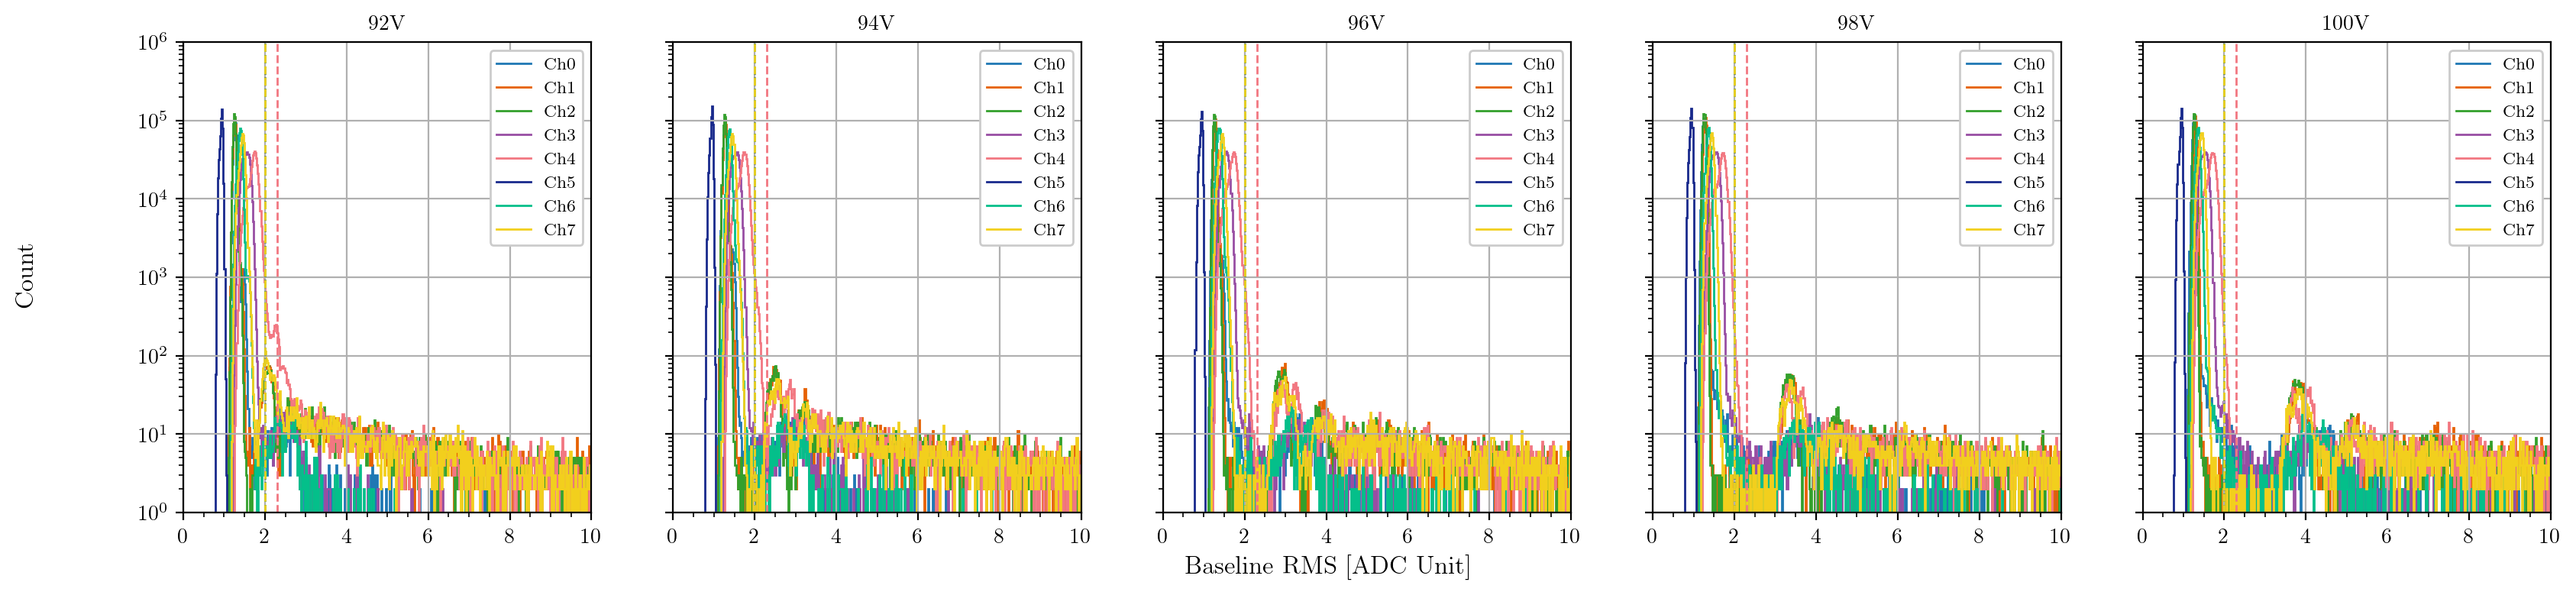

In [8]:
# Make plots for all datasets
# Baseline RMS
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True)
fig.set_size_inches(20, 4)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['rms_counts'],
            baseline[c][ch]['rms_bins'],
            label=f'Ch{ch}', color=f'C{j}'
        )
        th = rms_threshold[c][ch]
        axs[i].plot([th, th], [1, 1e6], f'C{j}--', linewidth=1)
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0)
fig.supylabel('Count', x=0.07)

Text(0.07, 0.5, 'Count')

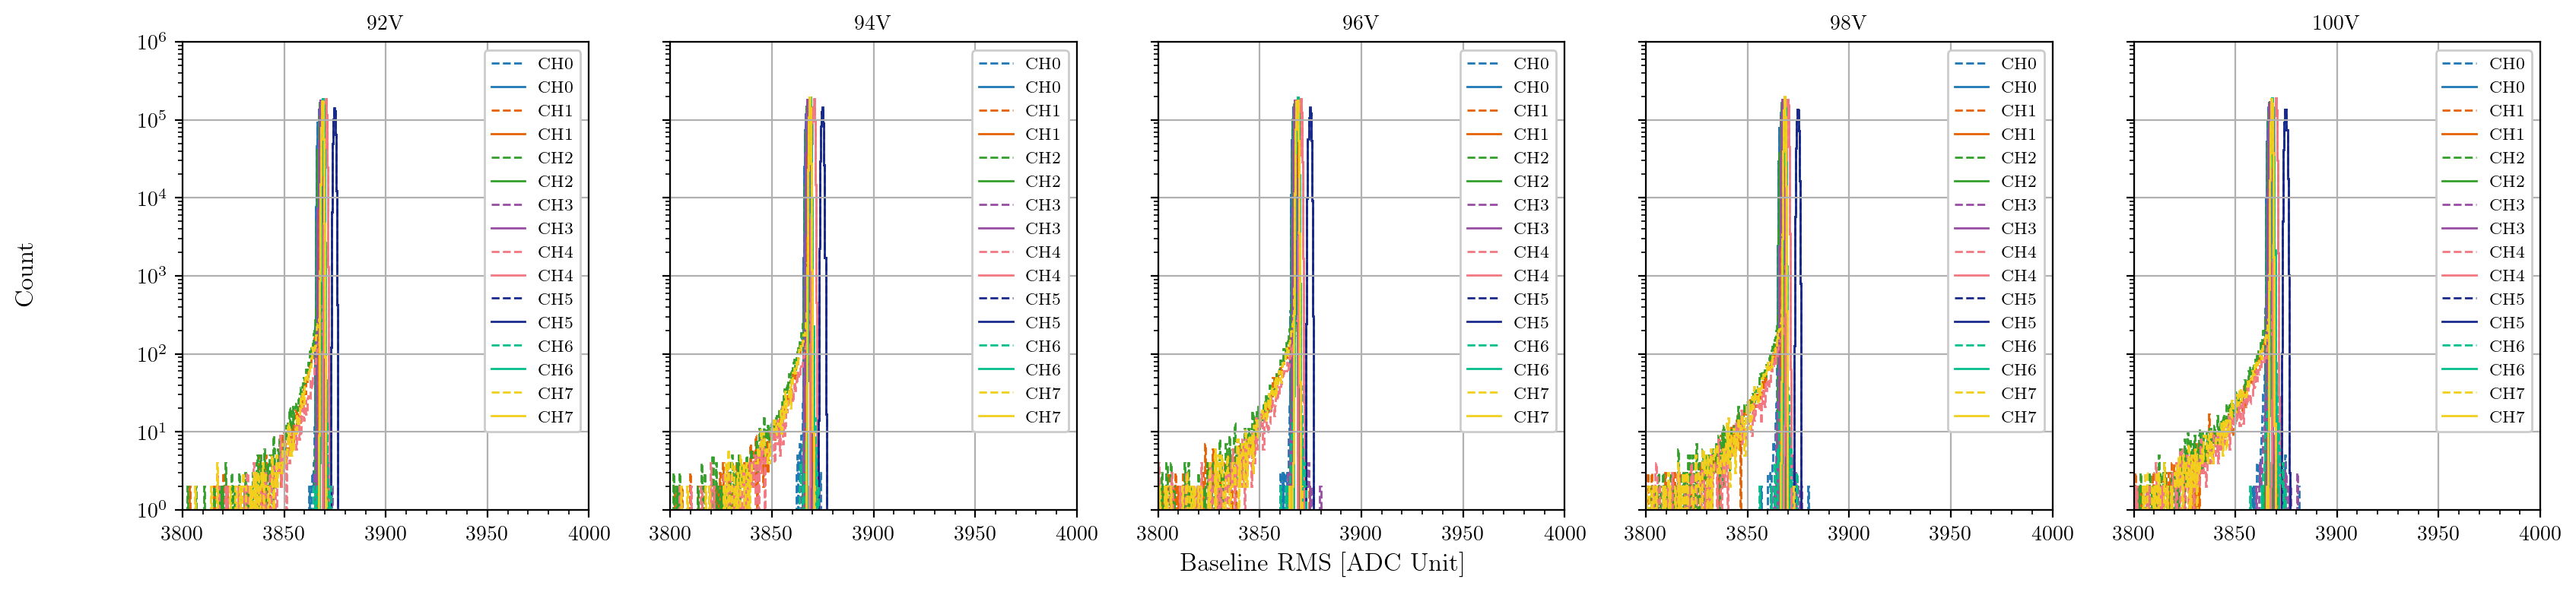

In [9]:
# Make plots for all datasets
# Baseline mean
fig, axs = plt.subplots(1, 5, sharex=True, sharey=True)
fig.set_size_inches(20, 4)
for i, c in enumerate(cond):
    for j, ch in enumerate(channels[1:]):
        axs[i].stairs(
            baseline[c][ch]['mean_counts'],
            baseline[c][ch]['mean_bins'],
            label=f'CH{ch}', color=f'C{j}', linestyle='--'
        )
        axs[i].stairs(
            baseline[c][ch]['mean_counts_filt'],
            baseline[c][ch]['mean_bins_filt'],
            label=f'CH{ch}', color=f'C{j}'
        )
    axs[i].legend(loc='upper right')
    axs[i].set_ylim(1, 1e6)
    axs[i].set_yscale('log')
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
fig.supxlabel('Baseline RMS [ADC Unit]', y=0)
fig.supylabel('Count', x=0.07)

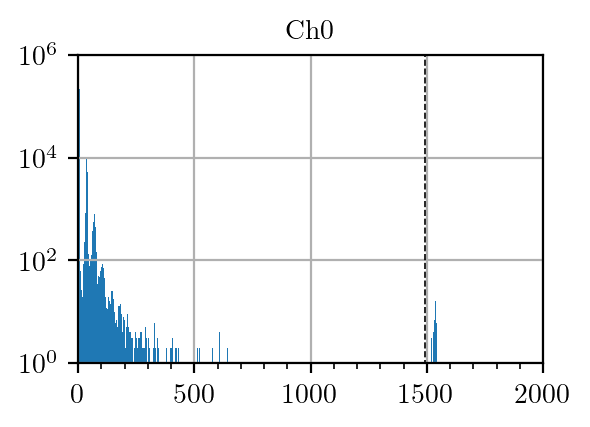

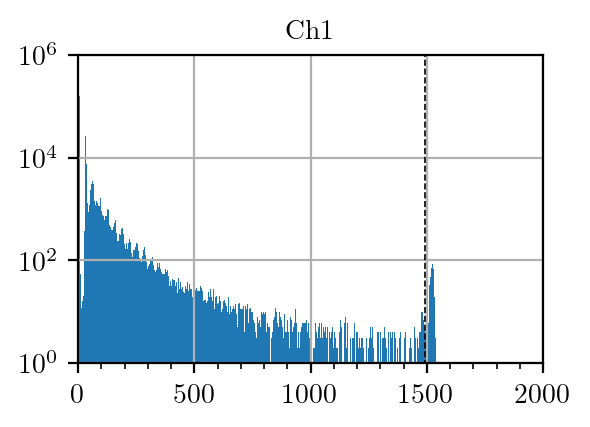

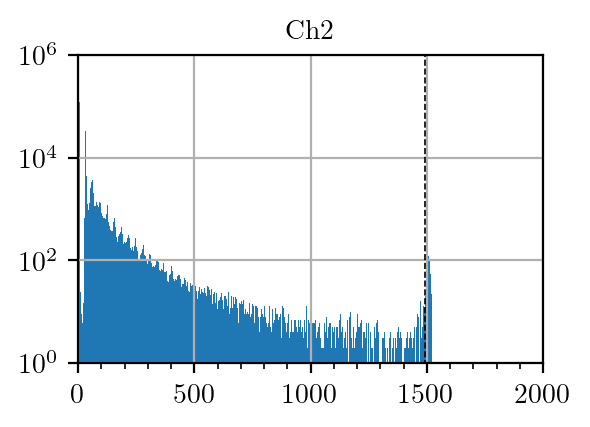

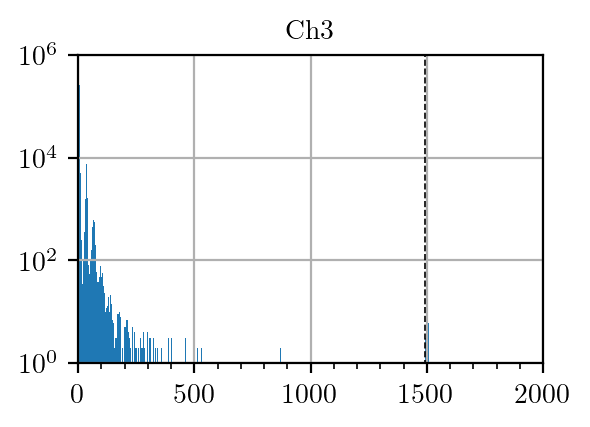

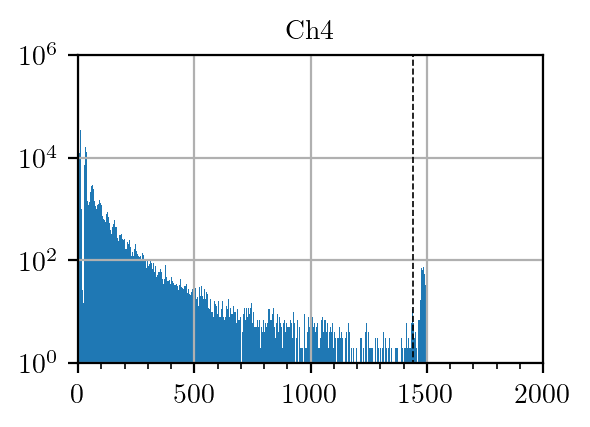

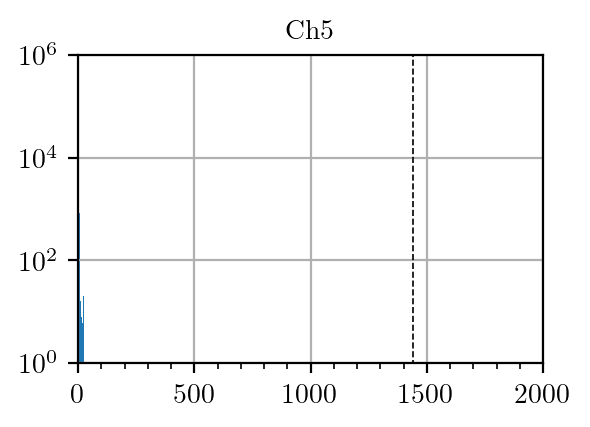

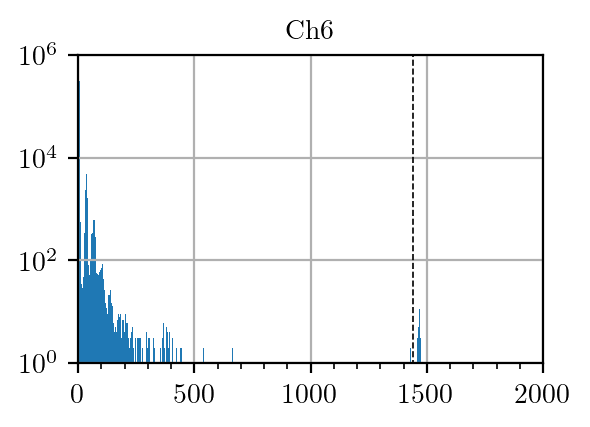

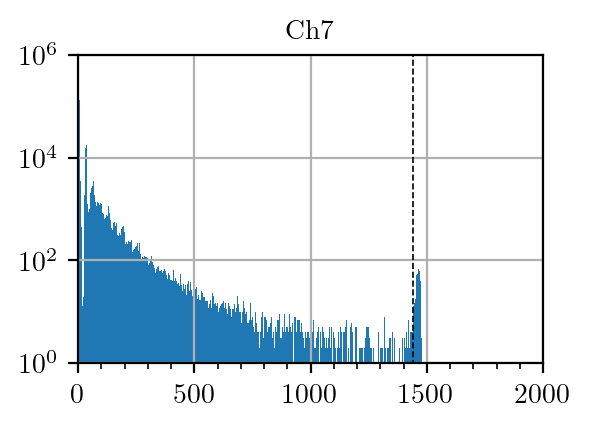

In [11]:
amp_sat = [1490]*4+[1440]*4
for ch in channels[1:]:
    plt.figure(ch,figsize=(3,2))
    plt.hist(data[cond[4]][f'amplitude_{ch}'],bins=np.linspace(0,1600,1000))
    plt.plot([amp_sat[ch]]*2,[0,1e6],'k--',linewidth=0.6)
    plt.title(f'Ch{ch}')
    plt.yscale('log')
    plt.grid()
    plt.minorticks_on()
    plt.ylim(0,1e6)
for c in cond:
    for ch in channels[1:]:
        data[c][f'sat_filt_{ch}'] = data[c][f'amplitude_{ch}']<amp_sat[ch]

In [12]:
# Initialize container
fprompt = {}
positions = ['all','fs','nofs']
for c in cond:
    fprompt[c] = {}
    for p in positions:
        fprompt[c][p] = {}

In [13]:
# Produce fprompt 2D histograms
nbinsx = 500
range_minx = -10
range_maxx = 600
nbinsy = 500
range_miny = 0
range_maxy = 1

for c in cond:
    data[c]['bsl_filt'] = data[c][[f'bsl_filt_{ch}' for ch in range(8)]].all(axis=1)
    data[c]['sat_filt'] = data[c][[f'sat_filt_{ch}' for ch in range(8)]].all(axis=1)
    filt = data[c]['bsl_filt']
    fprompt[c]['all']['fp_counts'], fprompt[c]['all']['fp_xbins'], fprompt[c]['all']['fp_ybins'] = np.histogram2d(
        data[c]['total_pe'][filt], 
        data[c]['fprompt_0p30us_01234567'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['fs']['fp_counts'], fprompt[c]['fs']['fp_xbins'], fprompt[c]['fs']['fp_ybins'] = np.histogram2d(
        data[c]['fs_pe'][filt], 
        data[c]['fprompt_0p30us_0356'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fprompt[c]['nofs']['fp_counts'], fprompt[c]['nofs']['fp_xbins'], fprompt[c]['nofs']['fp_ybins'] = np.histogram2d(
        data[c]['nofs_pe'][filt], 
        data[c]['fprompt_0p30us_1247'][filt], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    for p in positions:
        fprompt[c][p]['fp_counts'] = fprompt[c][p]['fp_counts'].T
        fprompt[c][p]['fp_xbins'], fprompt[c][p]['fp_ybins'] = np.meshgrid(
            fprompt[c][p]['fp_xbins'], fprompt[c][p]['fp_ybins']
        )
        fprompt[c][p]['fp_threshold'] = 0.1
    data[c]['fp_filt'] = data[c]['fprompt_0p30us_01234567']>fprompt[c]['all']['fp_threshold']
    data[c]['all_filt'] = data[c][['bsl_filt','sat_filt','fp_filt']].all(axis=1)

Text(0.07, 0.5, '$F_{\\rm 0.3\\mu s}$')

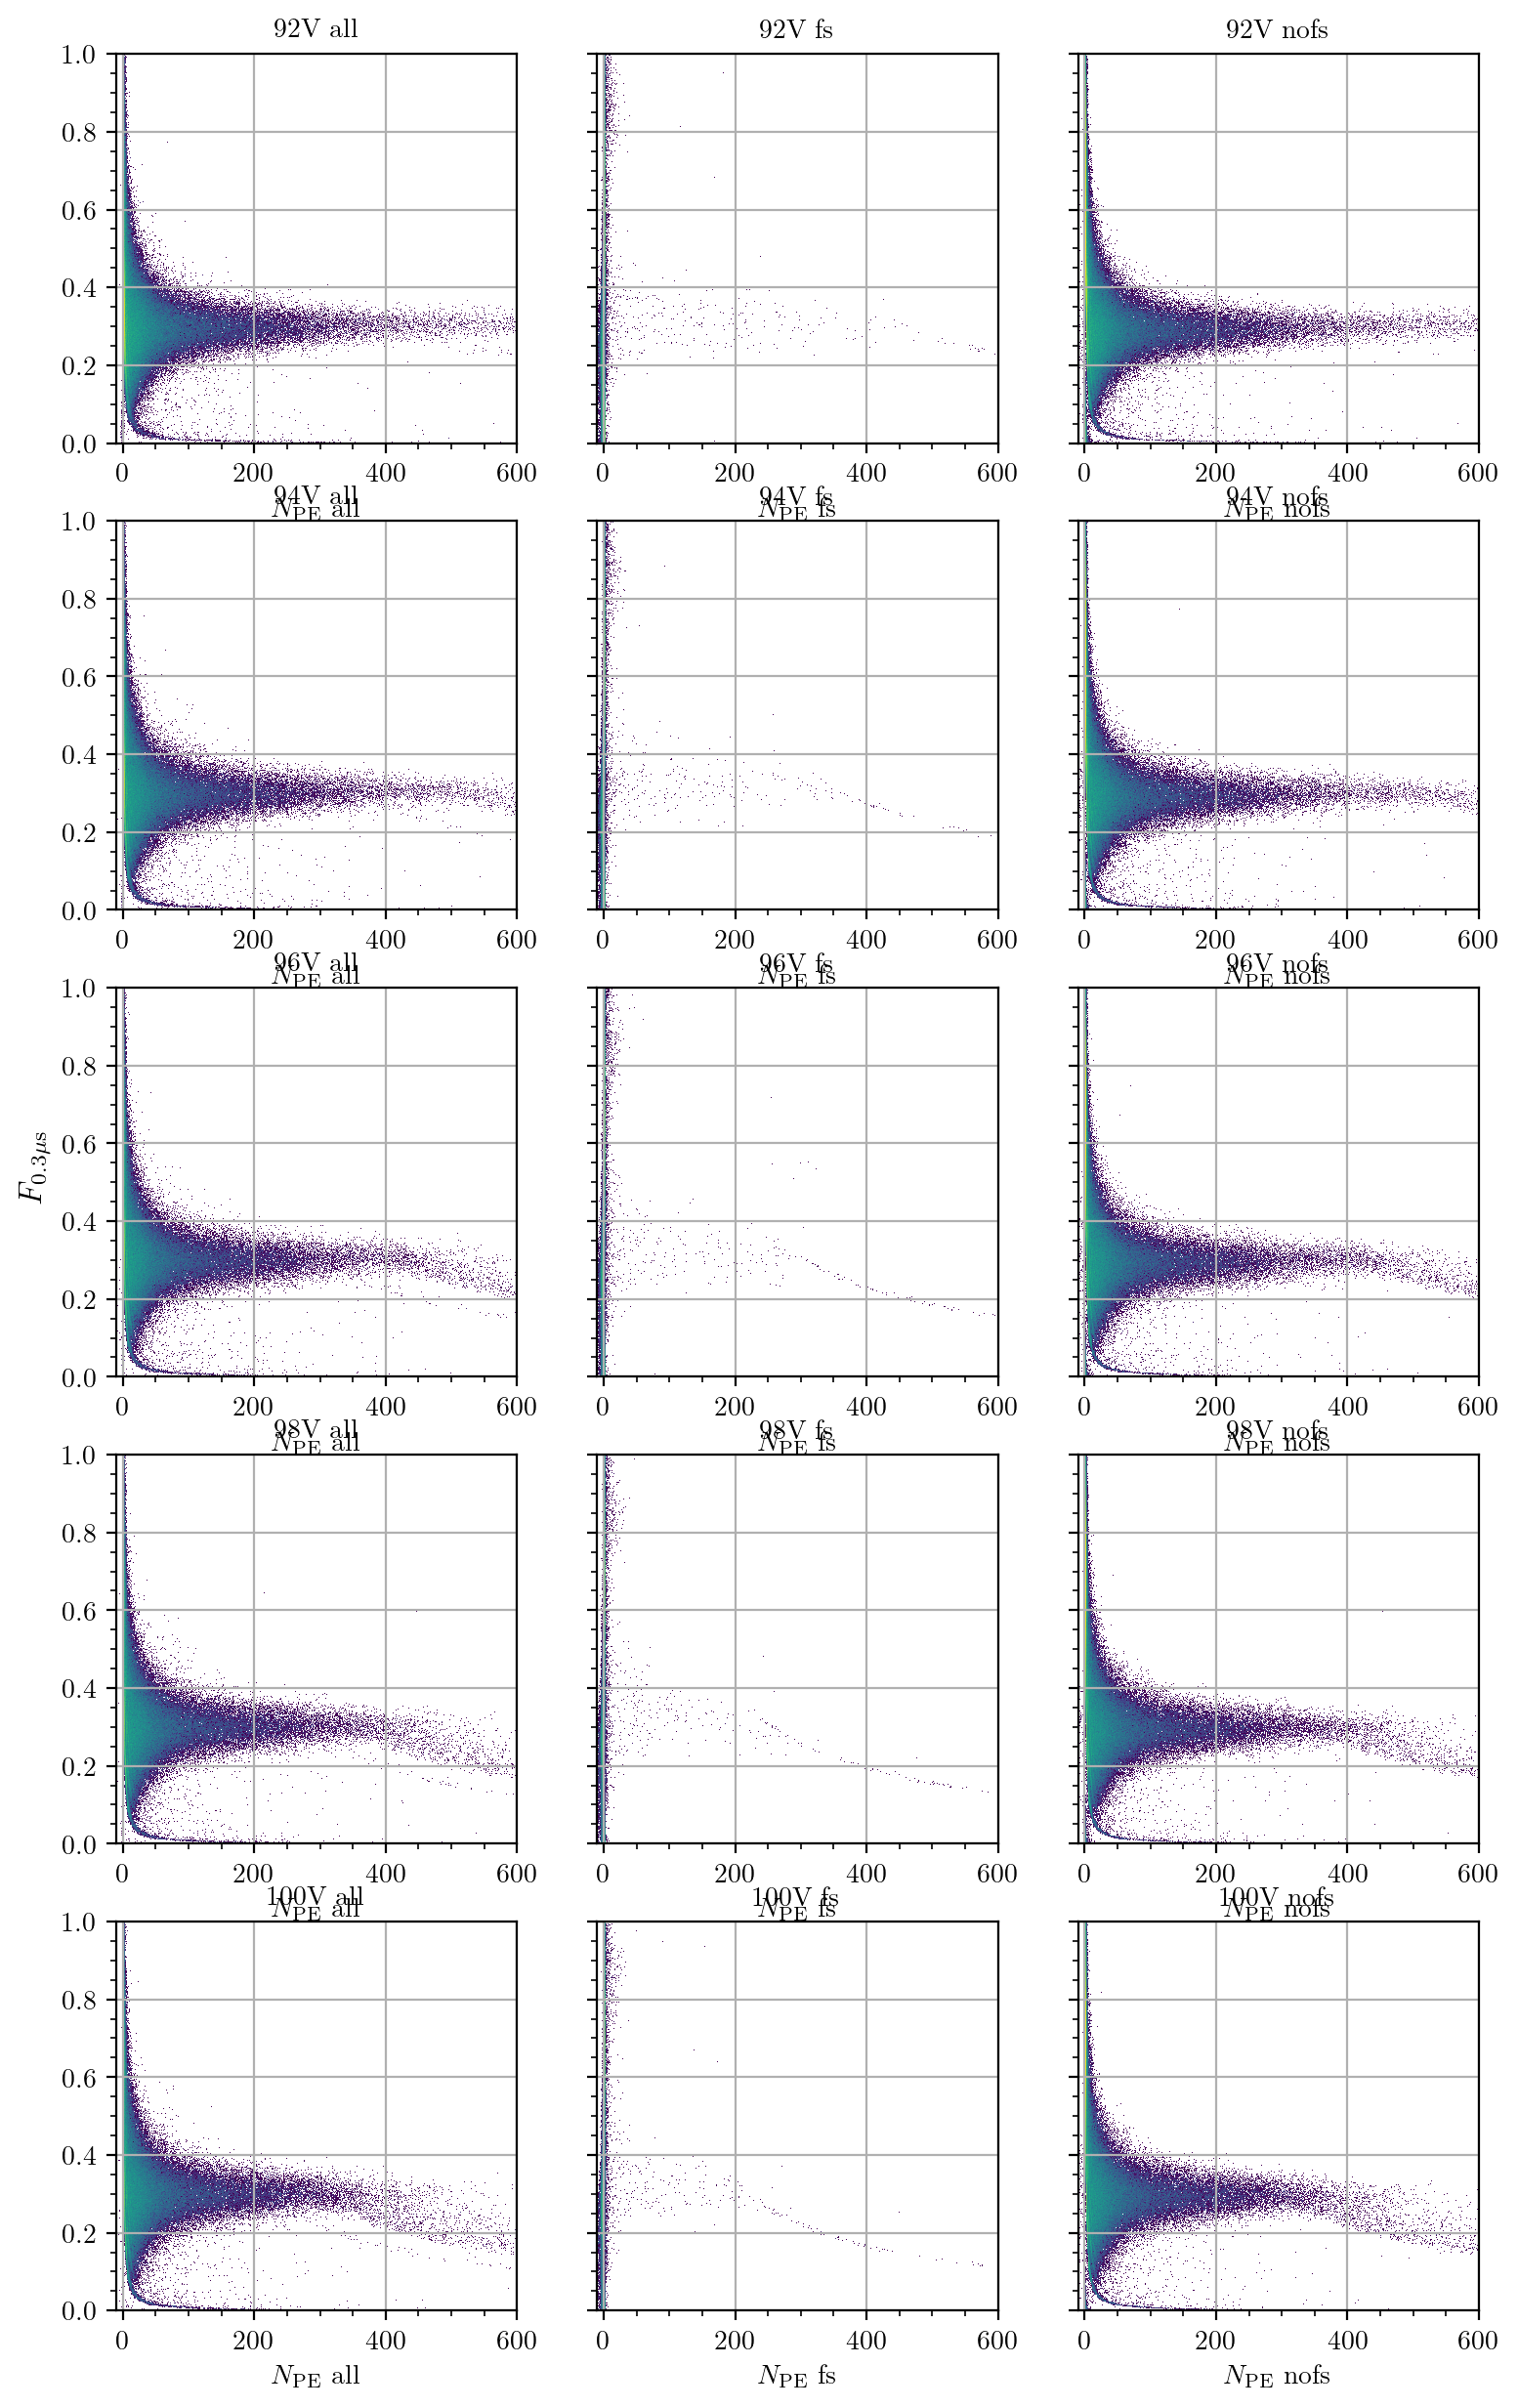

In [14]:
# Make plots for all datasets
# Fprompt
fig, axs = plt.subplots(5, 3, sharex=False, sharey=True)
fig.tight_layout(h_pad=5, w_pad=3)
fig.set_size_inches(9, 15)
for i, c in enumerate(cond):
    for j, p, in enumerate(positions):
        axs[i,j].pcolormesh(
            fprompt[c][p]['fp_xbins'],
            fprompt[c][p]['fp_ybins'],
            np.log10(fprompt[c][p]['fp_counts'])
        )
        th = fprompt[c][p]['fp_threshold']
        axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{c} {p}')
        axs[i,j].set_xlabel(r'$N_{\rm PE}$ ' + p)
fig.supylabel(r'$F_{\rm 0.3\mu s}$', x=0.07)

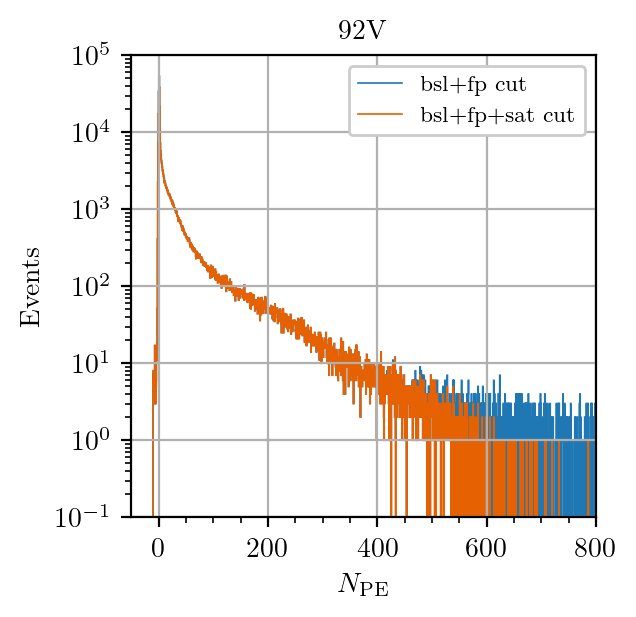

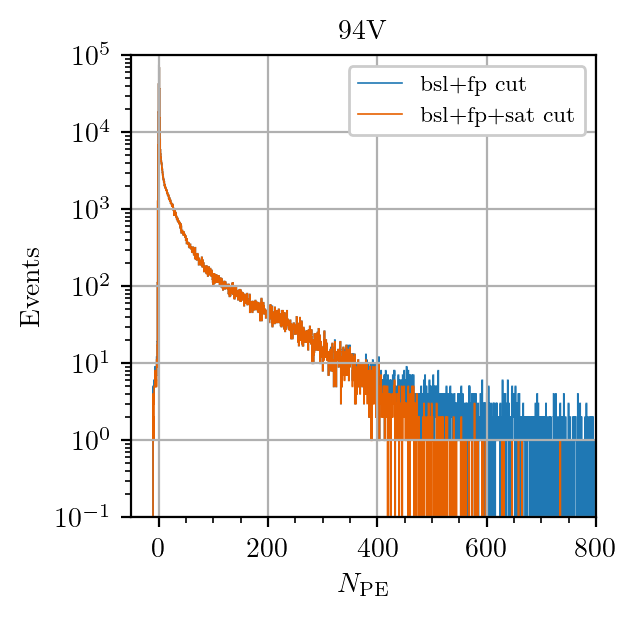

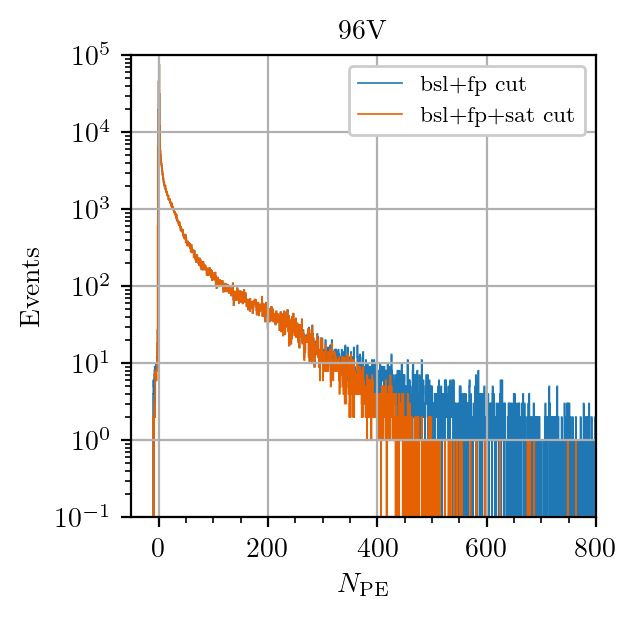

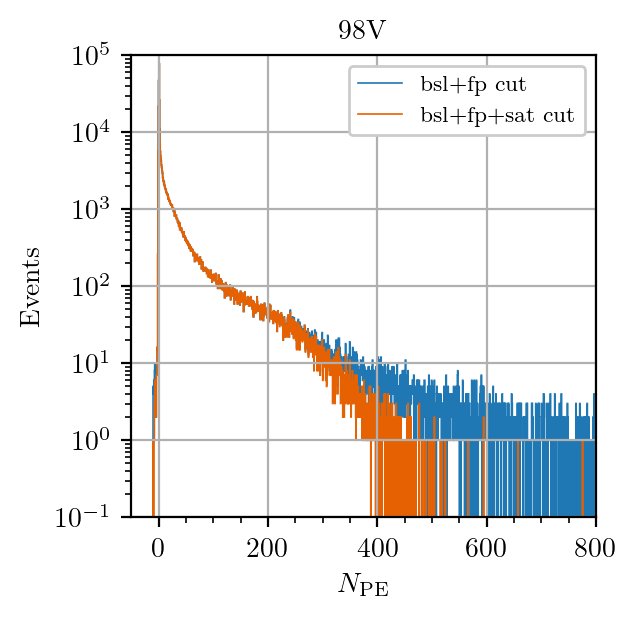

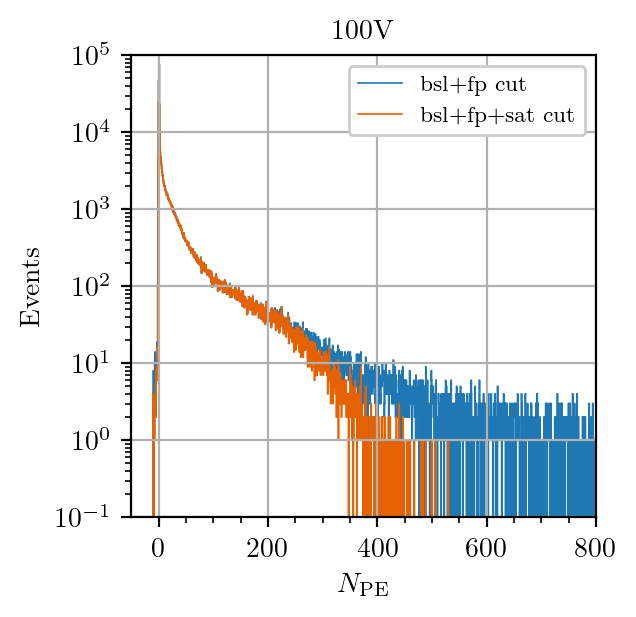

In [15]:
for i,c in enumerate(cond):
    filt1 = data[c]['bsl_filt'] & data[c]['fp_filt']
    filt2 = filt1 & data[c]['sat_filt']
    # hist0 = np.histogram(data[c]['nofs_pe'],bins=4000,range=(-10,2000))
    hist1 = np.histogram(data[c]['nofs_pe'][filt1],bins=4000,range=(-10,2000))
    hist2 = np.histogram(data[c]['nofs_pe'][filt2],bins=4000,range=(-10,2000))
    # hist3 = np.histogram(data[c]['nofs_pe'][filt3],bins=4000,range=(-10,2000))
    plt.figure(i,figsize=(3,3))
    # plt.stairs(*hist0,label='no cut',linewidth=0.6)
    plt.stairs(*hist1,label='bsl+fp cut',linewidth=0.6)
    plt.stairs(*hist2,label='bsl+fp+sat cut',linewidth=0.6)
    # plt.stairs(*hist3,label='bsl+sat+fp cut',linewidth=0.6)
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.grid()
    plt.minorticks_on()
    plt.xlim(-50,800)
    plt.ylim(1e-1,1e5)
    plt.title(c)
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel('Events')

In [16]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [17]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        # spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
        #     data[c]['nofs_pe'][data[c]['all_filt']] if w=='no' else data[c]['fs_pe'][data[c]['all_filt']], 
        #     bins=nbins, range=(range_min, range_max)
        # )
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data[c]['nofs_pe'][data[c]['bsl_filt'] & data[c]['fp_filt']] if w=='no' else data[c]['fs_pe'][data[c]['bsl_filt'] & data[c]['fp_filt']], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])
# for c in cond[:-1]:
#     spectra[c][w]['counts'] = spectra[c][w]['counts'] - spectra['Backgrounds'][w]['counts']*bkg_scale[c]
#     spectra[c][w]['errs'] = (spectra[c][w]['errs']**2 + (spectra['Backgrounds'][w]['errs']*bkg_scale[c])**2)**0.5

Text(0.06, 0.5, 'Events')

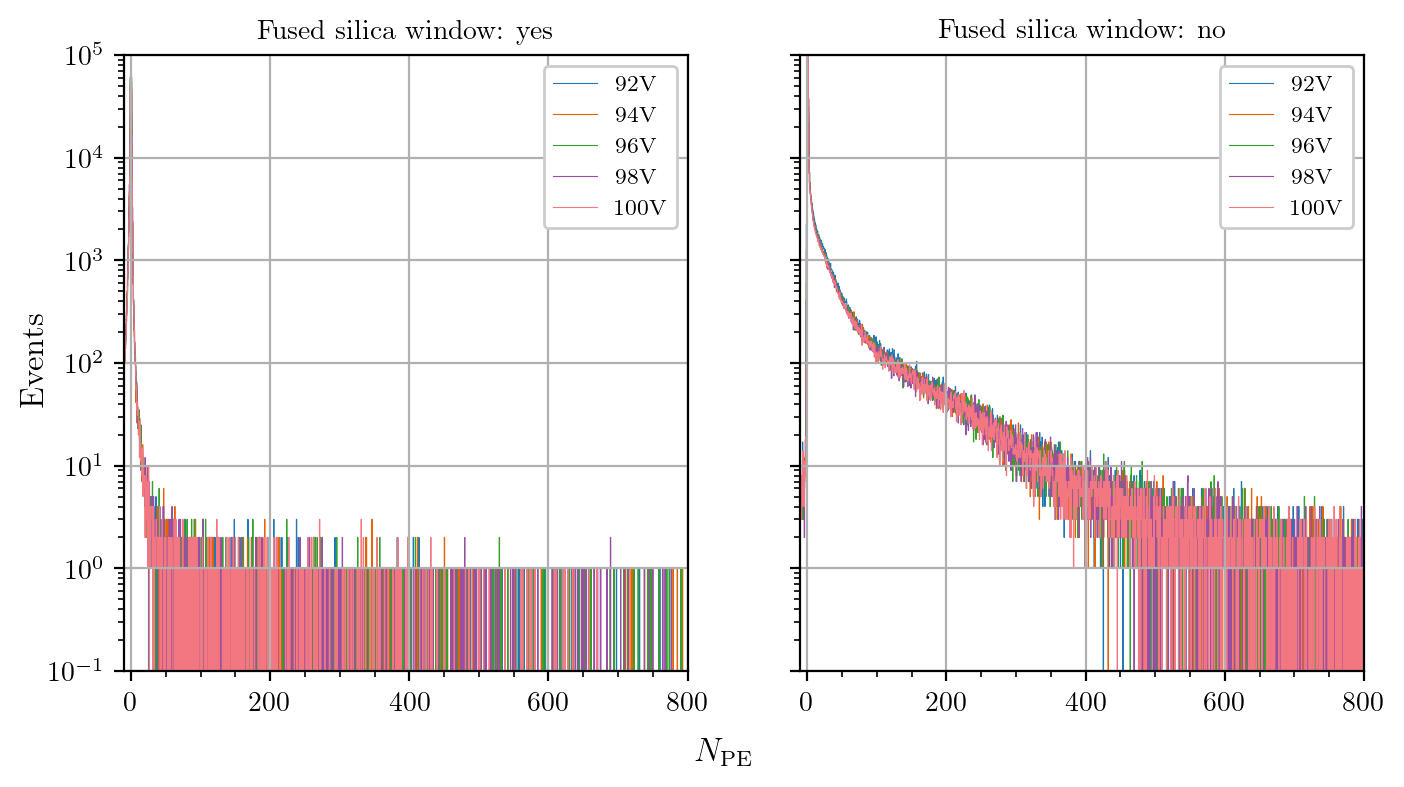

In [19]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(8, 4)
for j, w in enumerate(window):
    for i, c in enumerate(cond):
        axs[j].stairs(
            spectra[c][w]['counts'], 
            spectra[c][w]['bins'], 
            label=f'{c}', color=f'C{i}', linewidth=0.4
        )
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-1, 1e5)
    axs[j].set_xlim(-10, 800)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.01)
fig.supylabel('Events', x=0.06)

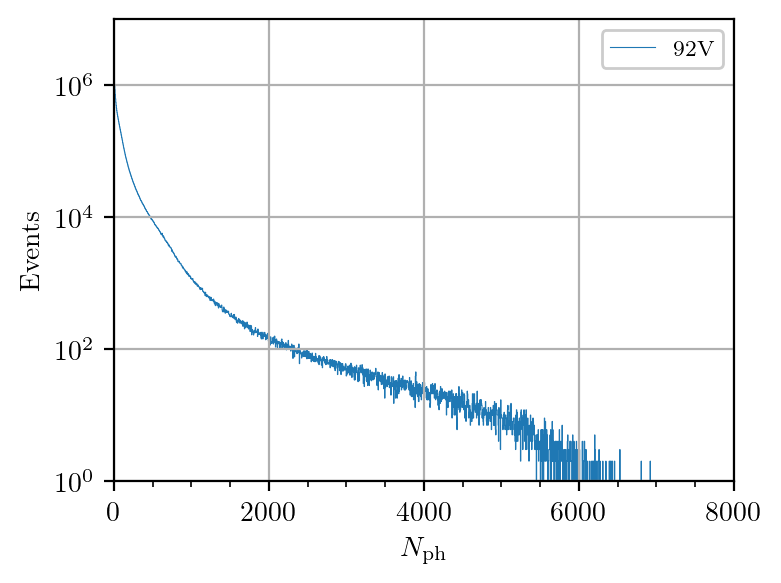

In [29]:
rtf = uproot.open(f'data/pe_hist/no_reflection/pu_lar_co60_hist.root')
hist_sim = rtf['nph_nofs_1247'].to_numpy()
plt.stairs(*hist_sim,linewidth=0.4,label=c)
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$N_{\rm ph}$')
plt.ylabel('Events')
plt.legend(loc='upper right')

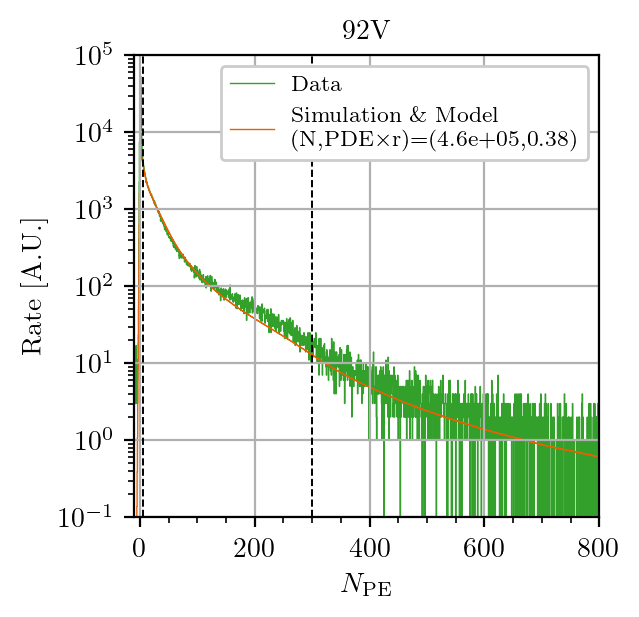

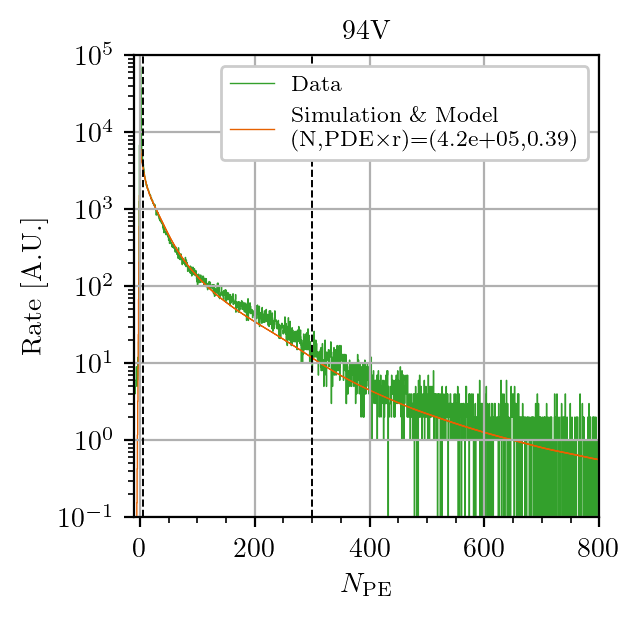

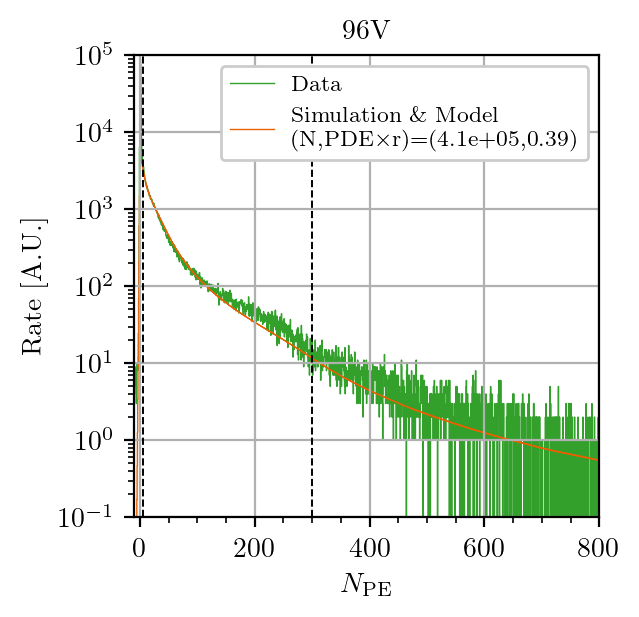

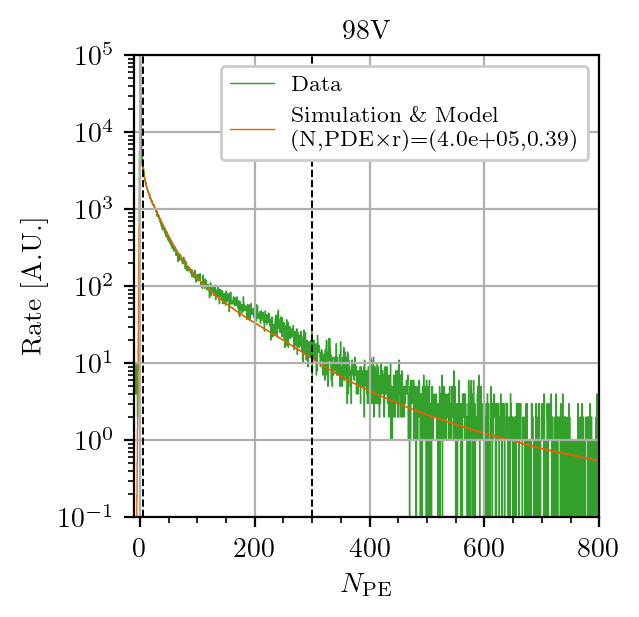

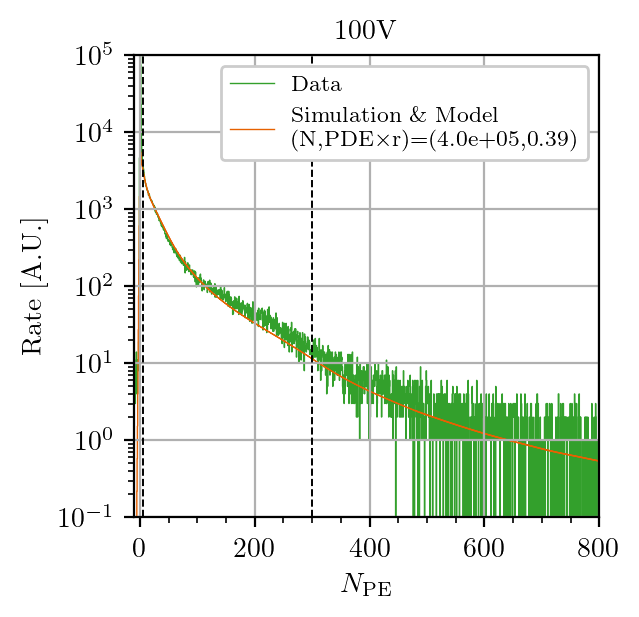

In [30]:
for i,c in enumerate(cond):
    plt.figure(i,figsize=(3,3))
    fit_range = (5,300)
    ymin, ymax = 1e-1,1e8
    smear = DetectorSmearing(fano=np.mean(calib[c]['fano'][[1,2,4,7]]),hist_in=hist_sim)
    par = smear.fit_to_data(
        data=(spectra[c]['no']['counts'],spectra[c]['no']['bins']),
        sigma=spectra[c]['no']['errs'],
        x0=[5e5,0.3*4/5],
        fit_range=fit_range
    )
    # par = [8e5,0.1,0.55*4/5]
    plt.stairs(spectra[c]['no']['counts'],spectra[c]['no']['bins'], label='Data', color='C2', linewidth=0.5)
    plt.stairs(*(smear.get_spectrum(spectra[c]['no']['bins'],*par)), label='Simulation \& Model\n'+r'(N,PDE$\times$r)='+f'({par[0]:.1e},{par[1]:.2f})', color='C1', linewidth=0.5)
    plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.ylim(1e-1,1e5)
    plt.xlim(-10,800)
    plt.legend(loc='upper right')
    plt.title(c)
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Rate [A.U.]')